<img src="figures/head.png" width=1000px alt="seys"/>

# Importar librerías

In [100]:
# Diferente forma de desplegar las figuras
%matplotlib notebook
# %matplotlib inline

# !pip install mpld3
# import mpld3
# mpld3.enable_notebook()

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib import patches
from matplotlib.pyplot import axvline, axhline
from collections import defaultdict
%config InlineBackend.figure_formats = ['svg']

from seys_utils import  escalon
from seys_utils import  cos
from seys_utils import  sinc
from seys_utils import  pulsoRect
from seys_utils import  recortar_y_enventanar
from seys_utils import  retardo
from seys_utils import  convolution
from seys_utils import  TFourier
from seys_utils import  iTFourier
from seys_utils import  plot_signal
from seys_utils import  plot_TF
from seys_utils import  zplane

# # Sacar para el repartido
# %reload_ext autoreload
# %autoreload 2
# %config InlineBackend.figure_format='retina'

signal_fig_size = (9.5,4)
fourier_fig_size = signal_fig_size

# Definiciones de señales y funciones

Las señales se *observan* durante $T_d$ (segundos) tomando muestras a $f_s$ (Hz).

# Transformadas de Fourier con DFT (FFT)

Las secuencias $x[n]$ que generamos son vectores de $f_s\times T_d$ muestras que se deben interpretar como el muestreo y enventanado de las señales de tiempo continuo $x(t)$ que queremos analizar.

Para analizar la Transformada de Fourier de $x[n]$ lo hacemos a través de la DFT (con el algoritmo de la FFT). La DFT queda $$X[k]=\sum_{n=0}^{N-1}x[n]w_N^{kn}$$ donde $$w_N=e^{-j\frac{2\pi}{N}}.$$
De esta misma definición recordemos que llegamos a  $$X[k]=X(e^{j\theta_k}), \textrm{ con } \theta_k=2\pi\frac{k}{N}$$

Hay diferencias importantes entre la Transformada de Fourier de la $x(t)$ y de $x[n]$. Conocer los fenómenos que generan esas diferencias son claves para poder hacer este análisis en tiempo discreto.


## Delta

La señal en el tiempo es $x(t)=\delta(t)$ y su transformada es $X(j\omega)=1$ (módulo 1 y fase 0 para todas las frecuencias). Veamos la DFT de $x[n]=\delta[n]$, $X[k]$ y si hay alguna diferencia con $X(j\omega)$.



In [102]:
Td = 0.025 # segundos
fs = 8000.0 # Hz

N = int(Td*fs)
tiempo = np.arange(-Td/2, Td/2, 1/fs)
muestras = np.zeros(N)
muestras[N//2] = 1

plot_signal(tiempo, muestras, "Delta")

<IPython.core.display.Javascript object>

In [105]:
# DTFT de la delta anterior
tdf, f = TFourier(muestras, fs)
plot_TF(f, tdf, muestras=True, semilogy=False)

<IPython.core.display.Javascript object>

### Observaciones
La DFT queda $$X[k]=\sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi}{N}kn}$$ con $x[n]=[0,\dots, 0,1, 0,\dots, 0]$ siendo diferente de cero en $n=N/2$. Por lo tanto $$X[k]=e^{-j\pi k}=(-1)^k$$ con módulo $|X[k]|=1\forall k$, y fase  $\langle X[k]=0$ en $k$ par y $\langle X[k]=\pi$ en $k$ impar.

<IPython.core.display.Javascript object>


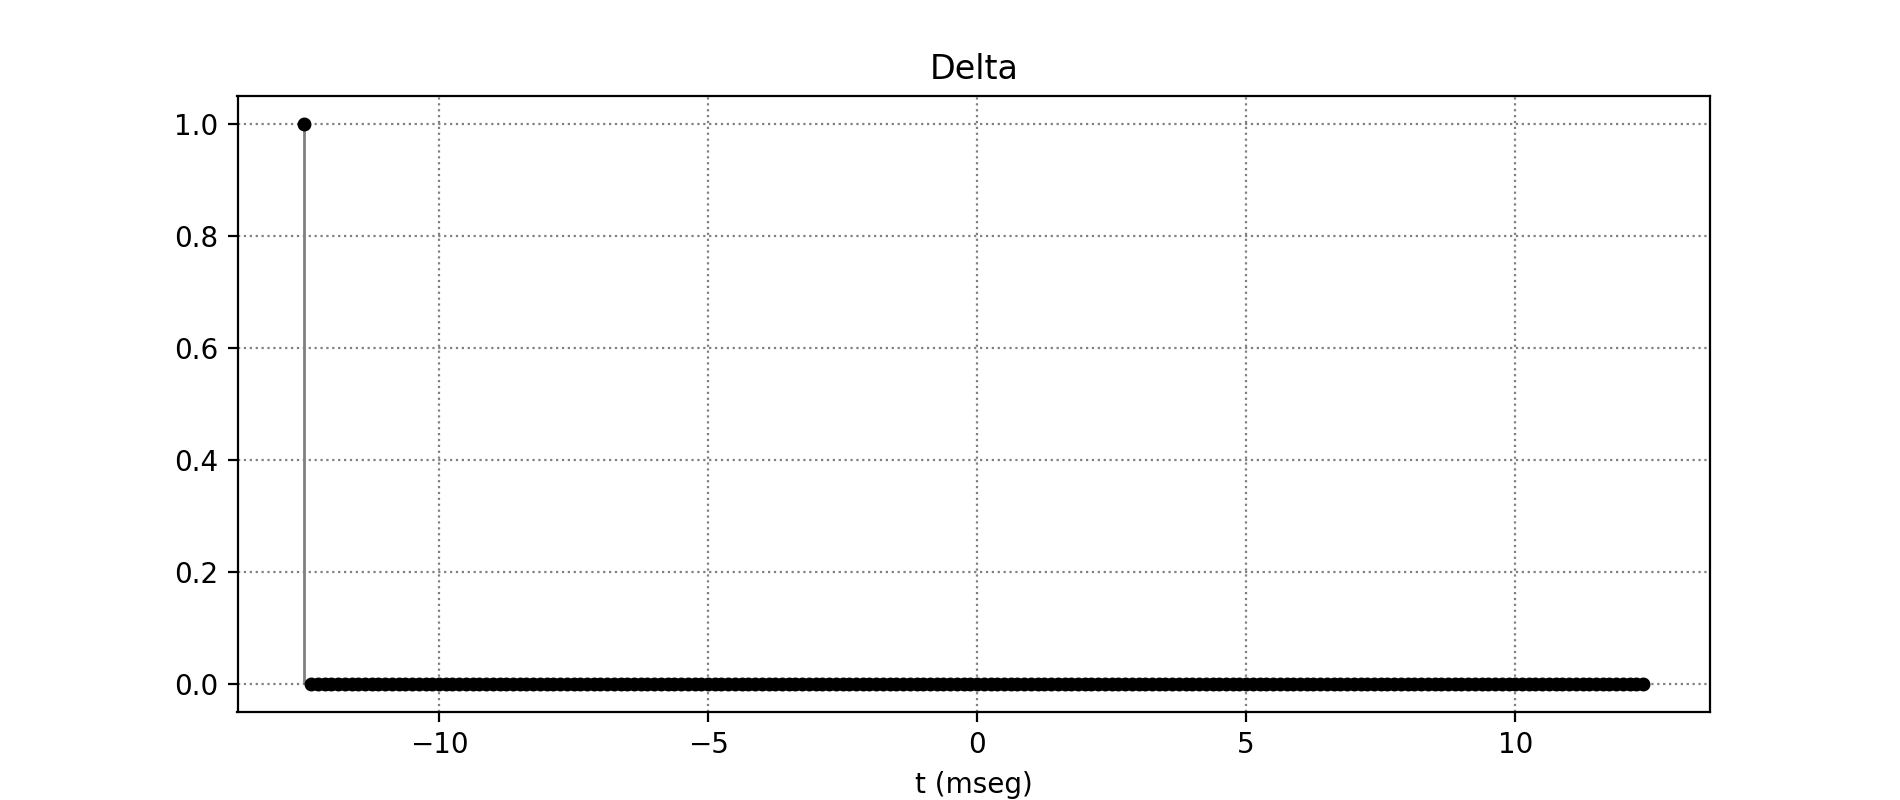

<IPython.core.display.Javascript object>


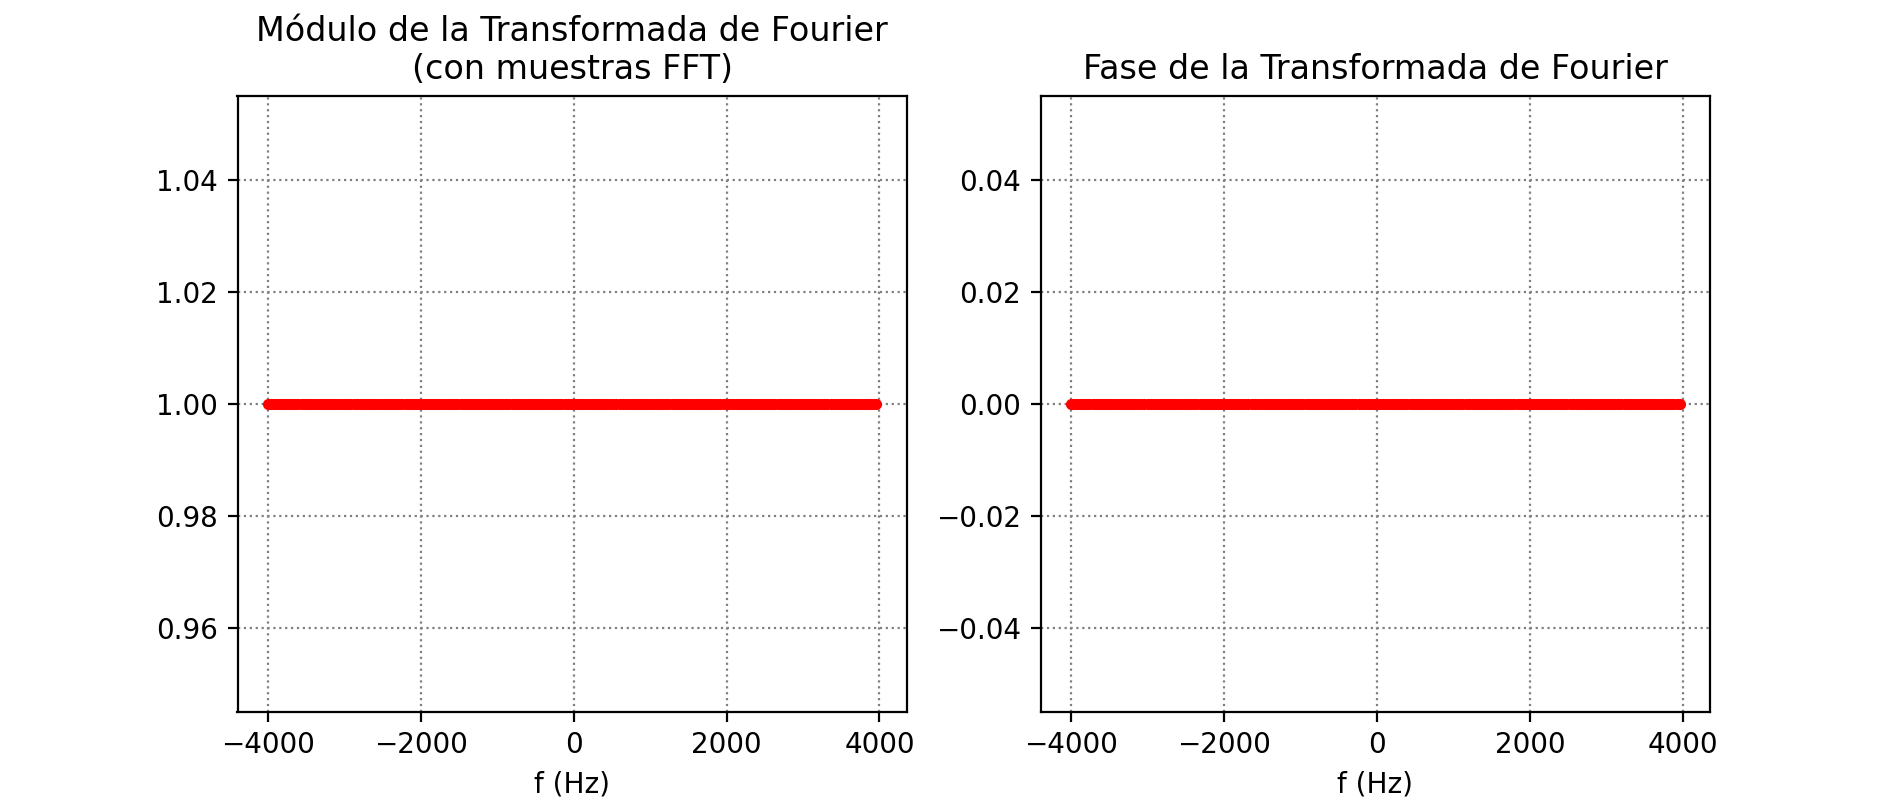

In [36]:
x1 = retardo(muestras, -N//2)

plot_signal(tiempo, x1, "Delta")

tdf, f = TFourier(x1, fs)
plot_TF(f, tdf, muestras=True)

## Pulso Rectangular:  $x(t) = \Pi\left(\frac{t}{T_a}\right)$

* Ancho del pulso  $T_a = 12.5~ms$
* Ventana de tiempo $T_d=25~ms$
* Frecuencia de muestreo $f_s = 8~kHz$
* Cantidad de muestras $N=T_d \times\ f_s = 200$

In [114]:
Td = 0.02
fs = 8000.
Ta = 0.0125
m, t = pulsoRect(Td, fs, Ta)
plot_signal(t, m, "Pulso rectangular")

<IPython.core.display.Javascript object>

###  Transformada del pulso continuo $X(f) = T_a \textrm{sinc}(T_a f)$

* Altura máxima:  $T_a$
* Cruza por cero en múltiplos de $\frac{1}{T_a}$

In [115]:
print("Número de puntos evaluados en la FFT, N =", Td*fs)
print("Corte por cero en 1/Ta =", 1/Ta)
print("Distancia entre muestras (resolución) cada 1/Td =", 1/Td)
print("Altura de la FFT (muestreada) fs*Ta =", fs*Ta)

tdf, f = TFourier(m, fs)
plot_TF(f, tdf)
plot_TF(f, tdf, True, )

Número de puntos evaluados en la FFT, N = 160.0
Corte por cero en 1/Ta = 80.0
Distancia entre muestras (resolución) cada 1/Td = 50.0
Altura de la FFT (muestreada) fs*Ta = 100.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Aumento de la resolución en frecuencia por el agregado de ceros en la evaluación de la FFT


* Ancho del pulso  $T_a = 12.5~ms$
* Ventana de tiempo $T_d=25~ms$
* Frecuencia de muestreo $f_s = 8~kHz$
* Cantidad de muestras $N=T_d \times\ f_s = 200$
* Agregado de 800 ceros.



In [113]:
Td = 0.02
fs = 8000.
Ta = 0.0125
nZeros = 800

m, t = pulsoRect(Td, fs, Ta)
plot_signal(t, m, "Pulso rectangular")

tdf, f = TFourier(m, fs)
plot_TF(f, tdf, True)

m_ceros = np.concatenate((m,np.zeros(nZeros)))
t_aux = np.arange(Td/2, Td/2 + nZeros/fs, 1/fs)
t_ceros = np.concatenate((t,t_aux))
plot_signal(t_ceros, m_ceros, "Pulso rectangular con ceros agregados")

tdf, f = TFourier(m_ceros, fs, nZeros)
plot_TF(f, tdf, True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Escalón



In [112]:
Td = 0.02
fs = 8000.

m, t = escalon(Td, fs)
plot_signal(t, m)

tdf, f = TFourier(m, fs, 800)
plot_TF(f, tdf,'True')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

La Transformada del escalón $\mathcal{F}\{u(t)\}=\frac{1}{j\omega}+\pi\delta(\omega)$. 

¿Se parece? 

¿Qué es?

## Seno cardinal (sinc) de ancho de banda $W$:   $\textrm{sinc}(2W t)$
* Primer corte con cero en $\frac{1}{2W}$
* Ventanan de tiempo $T_d = 8s$
* Frecuencia de muestreo $f_s = 10Hz$
* Cantidad de muestras $N = T_d \ F_s = 80$



In [116]:
Td = 0.025
fs = 8000.
W = 400

m, t = sinc(Td, fs, W)
# m = 2*W*m
plot_signal(t, m, "Seno cardinal de ancho de banda %.0f Hz" % W )

<IPython.core.display.Javascript object>

### Transformada del Seno cardinal (sinc) de ancho de banda $W$: $X(f) = \frac{1}{2W}\Pi\left(\frac{f}{2W}\right)$

* Ancho del pulso  $2W$
* Muestreada cada $\frac{1}{T_d}$
* Cantidad de muestras $N=T_d \times\ f_s$
* Altura $\frac{f_s}{2W}$

In [117]:
nZeros = 0
tdf, f = TFourier(m, fs, nZeros)
plot_TF(f,tdf, True)

<IPython.core.display.Javascript object>

### Transformada después de agregar ceros

In [118]:
nZeros = 800
tdf, f = TFourier(m, fs, nZeros)
plot_TF(f,tdf, True)

<IPython.core.display.Javascript object>

# Convolución

## Convolución de dos pulsos  $x(t) = \Pi\left(\frac{t}{T_a}\right) \Leftrightarrow y(t) = T_a\Lambda\left(\frac{t}{T_a}\right)$

<IPython.core.display.Javascript object>


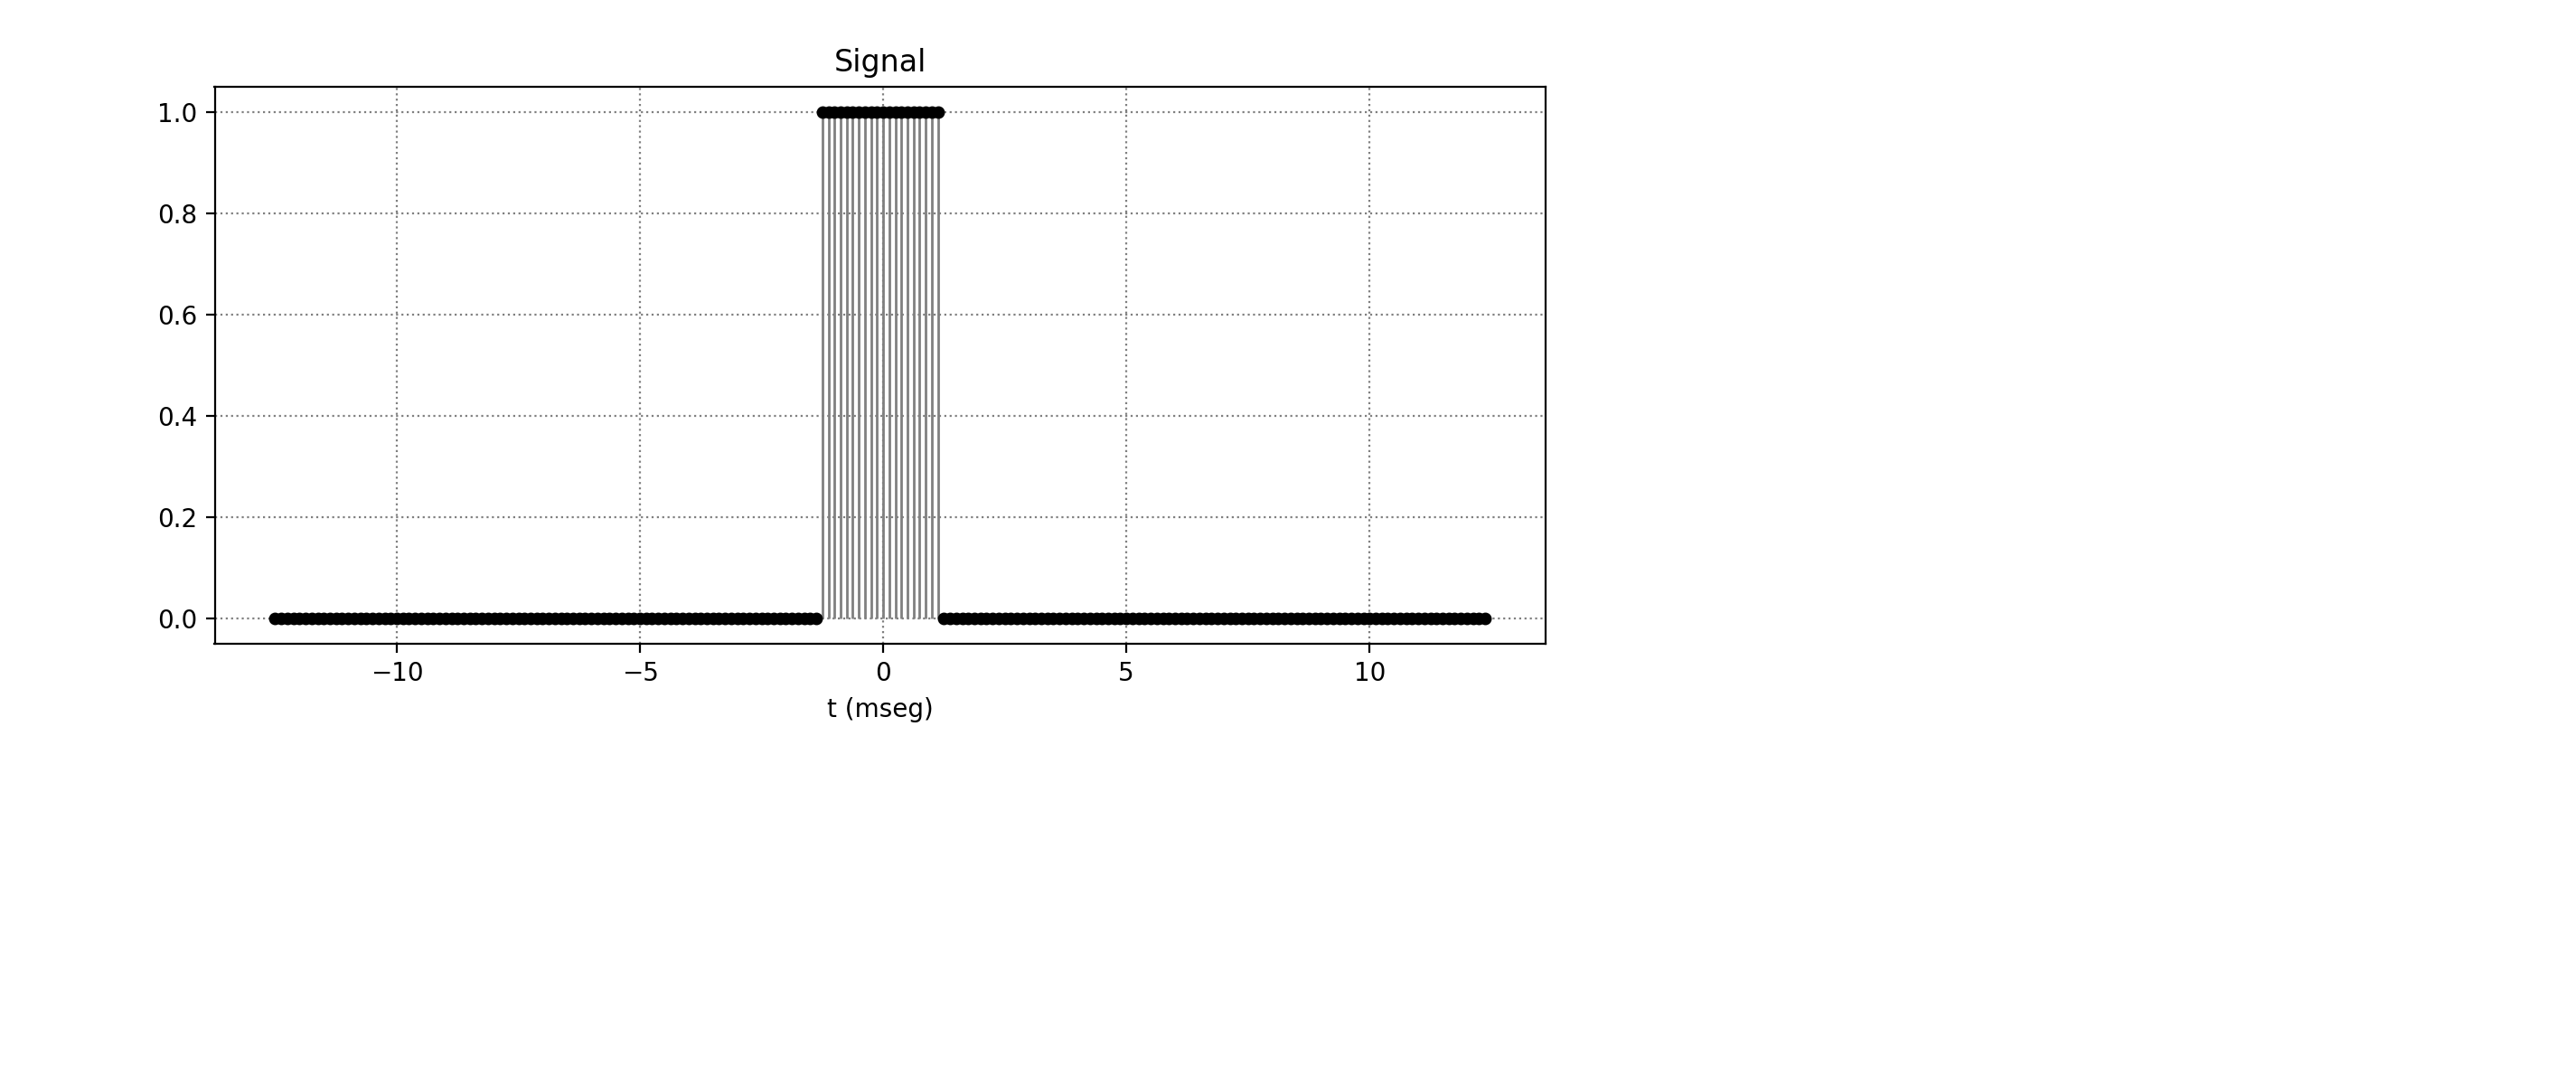

<IPython.core.display.Javascript object>


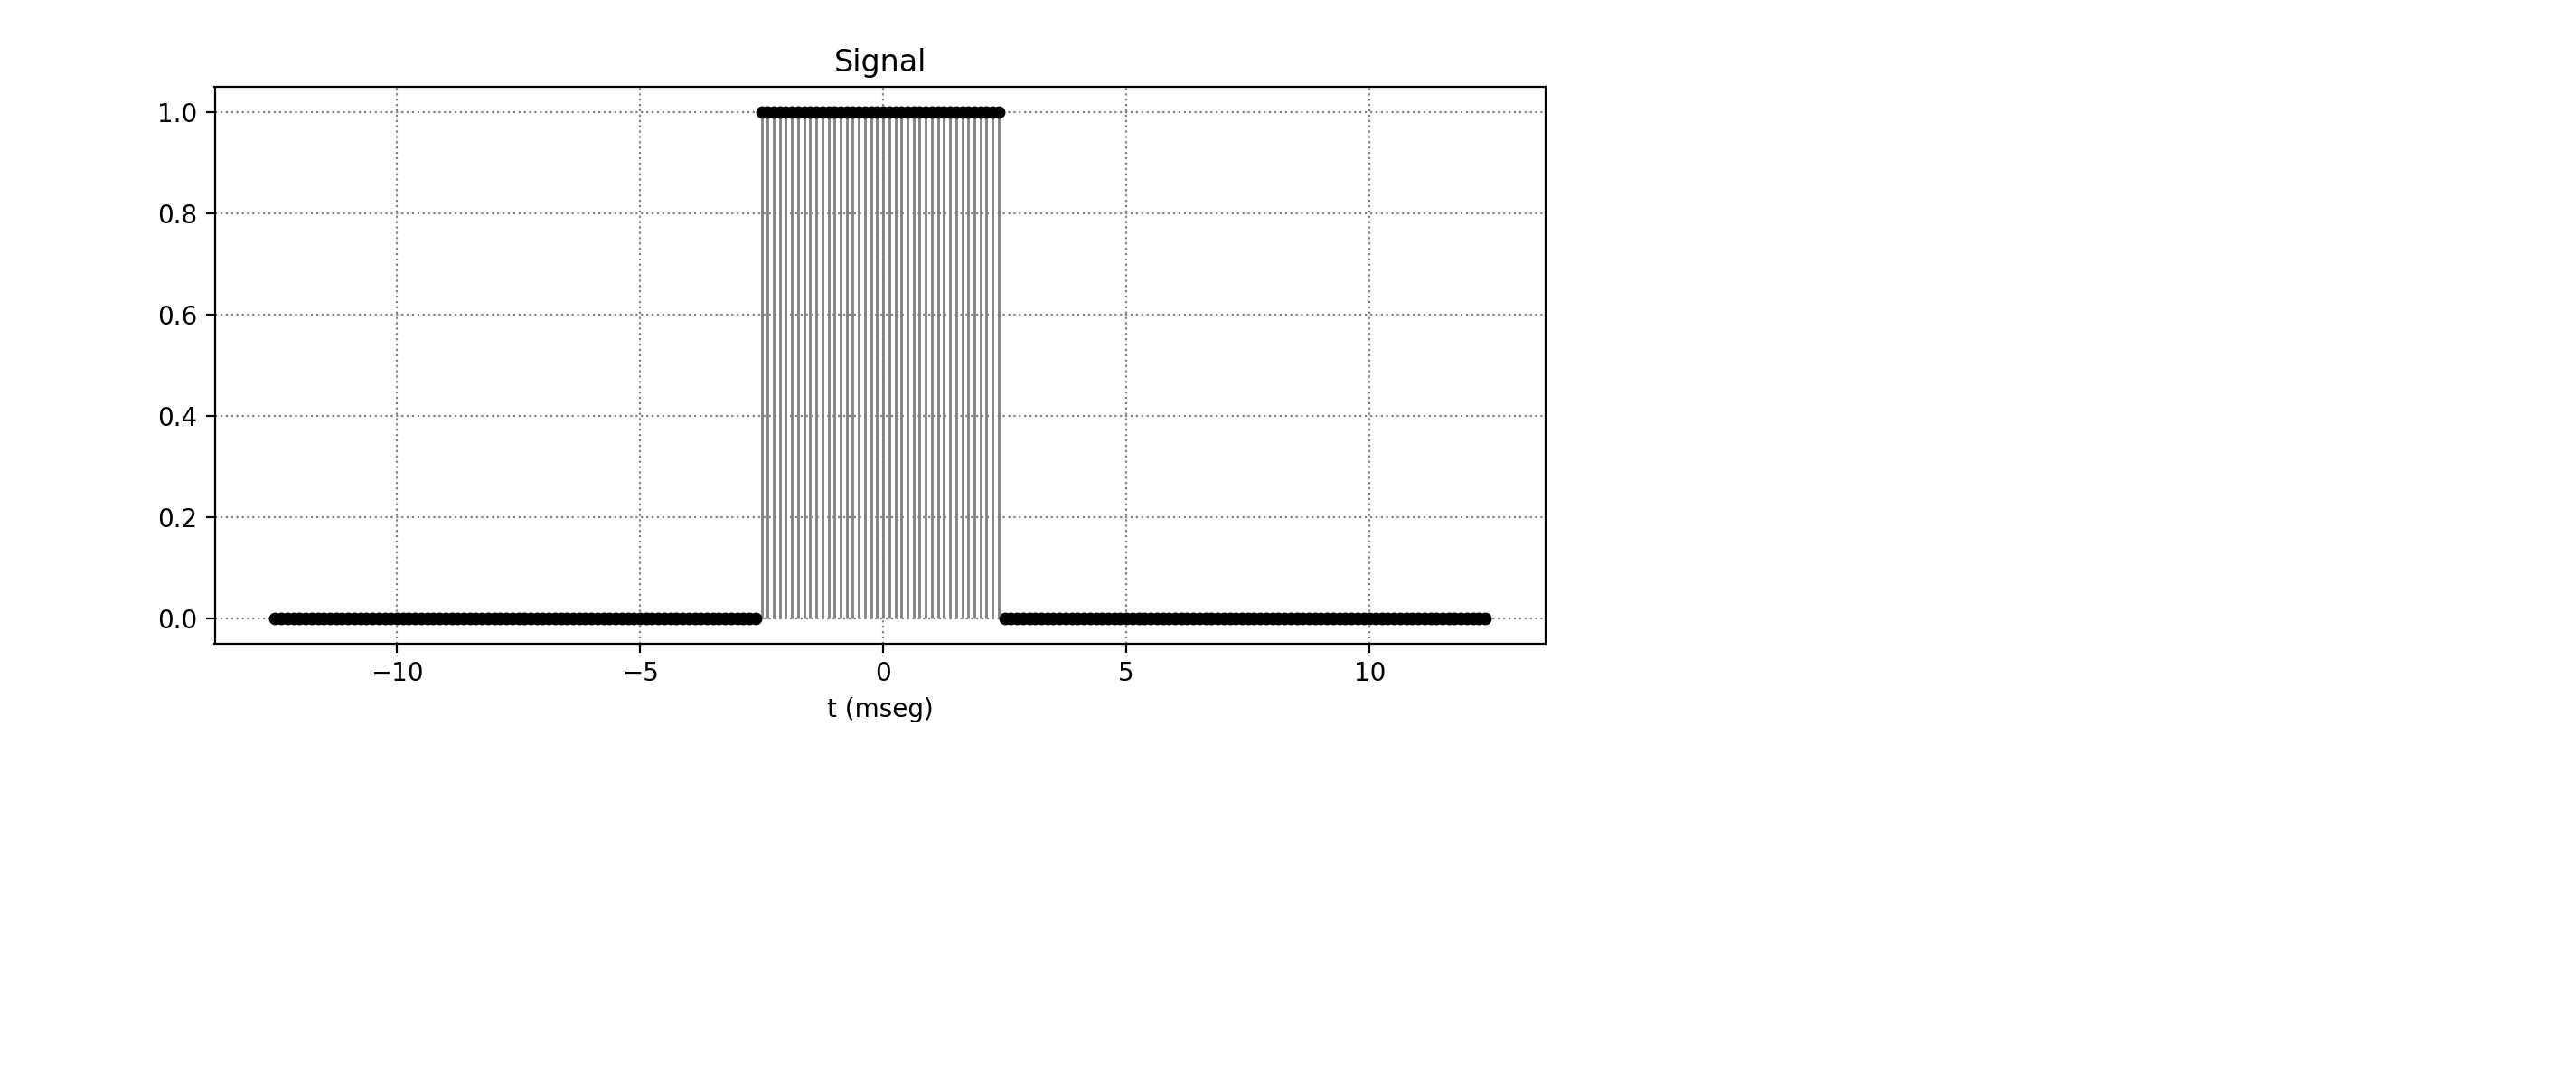

<IPython.core.display.Javascript object>


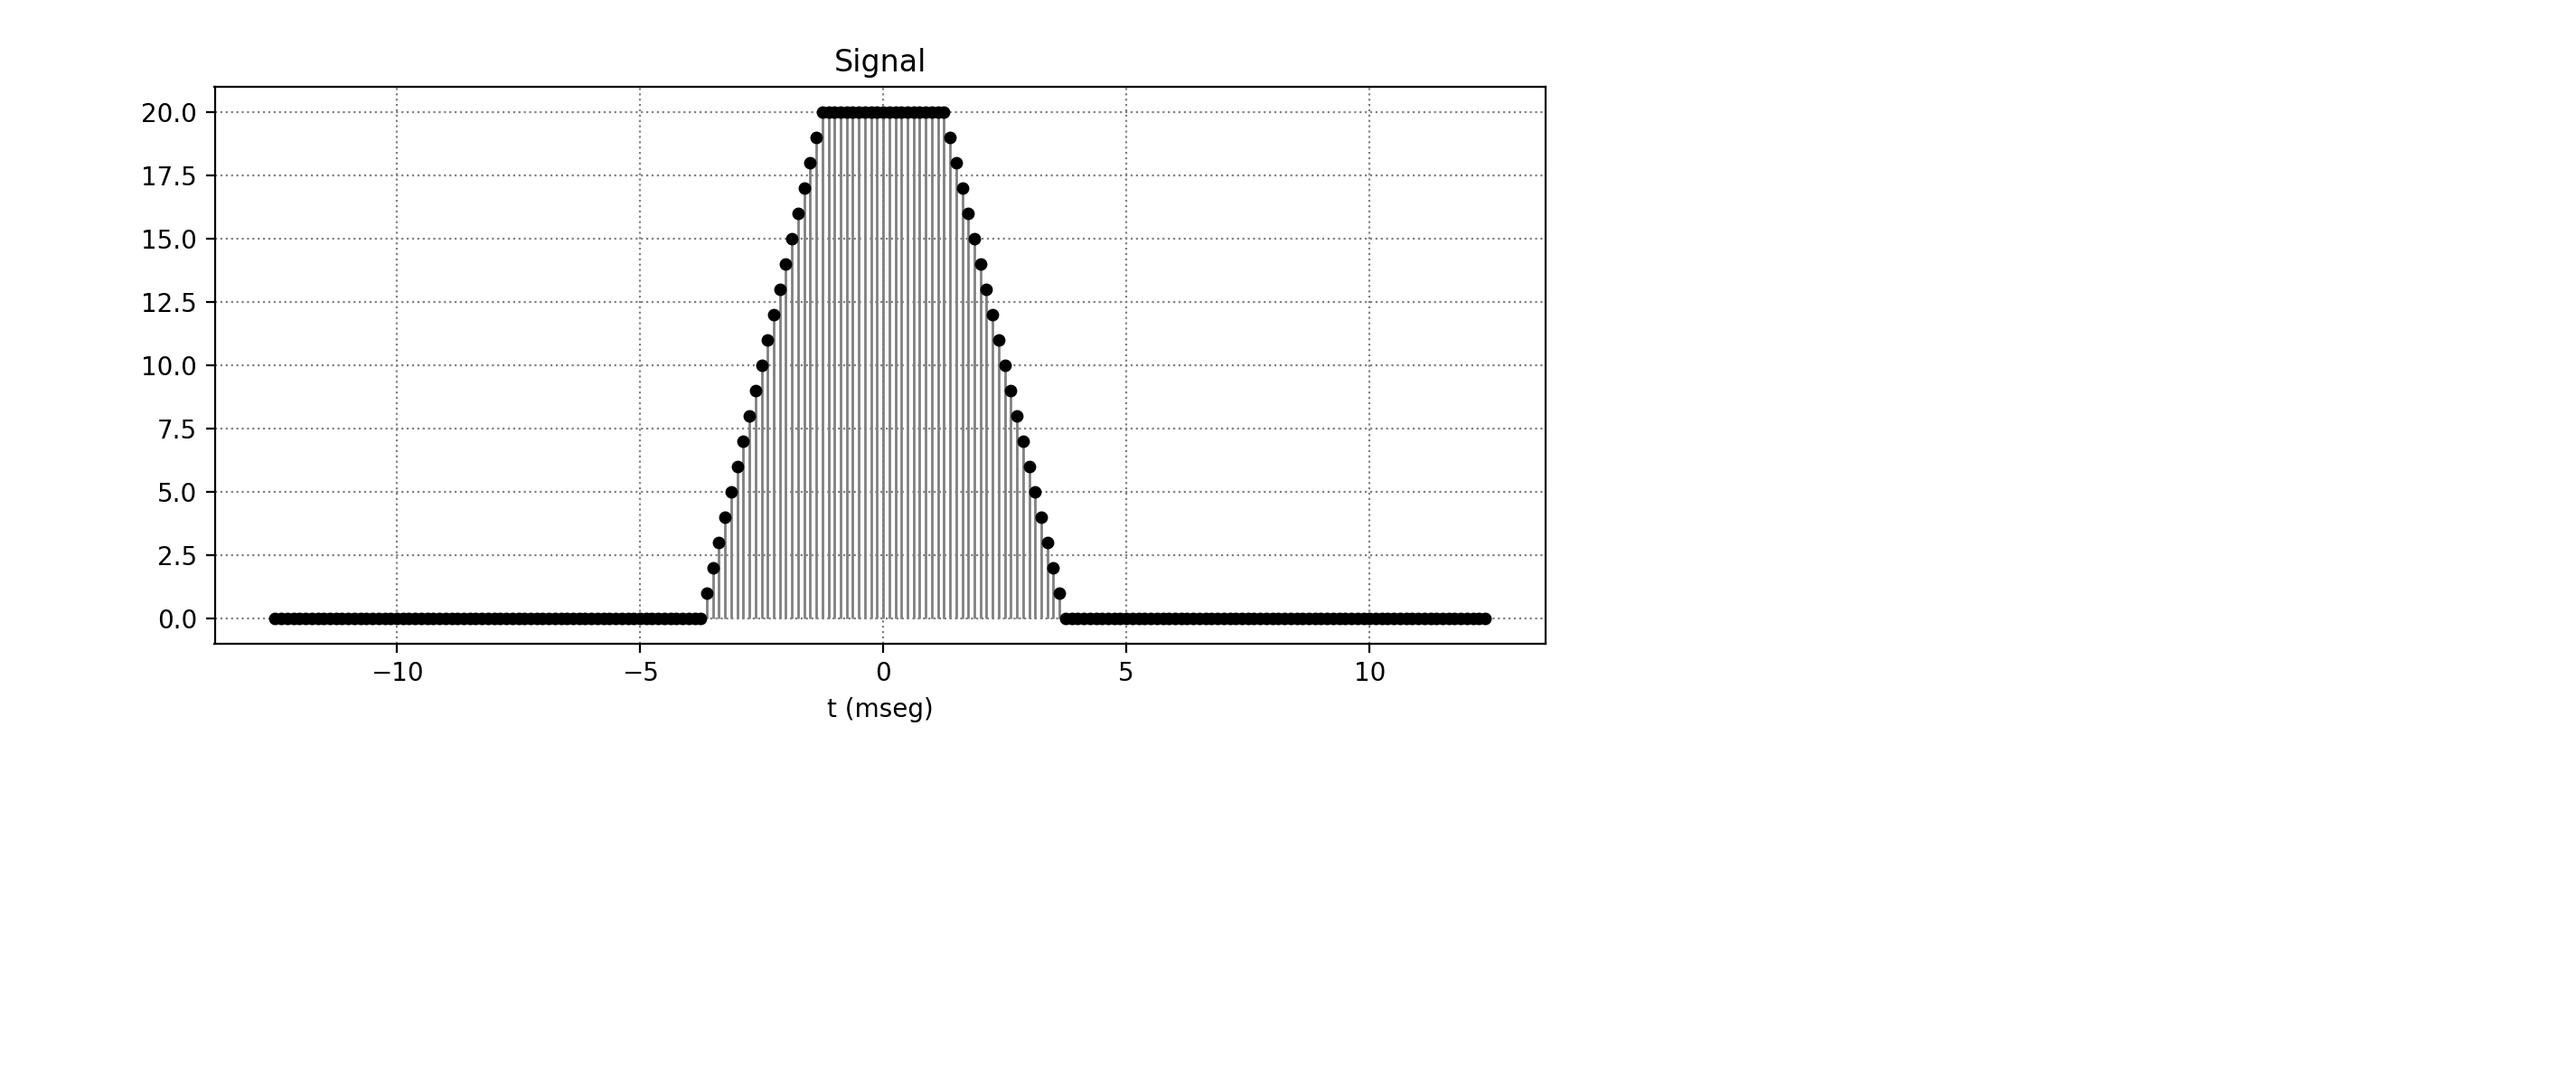

In [120]:
Td = 0.025
fs = 8000.
Ta1 = 0.0025
Ta2 = 0.005

m1, t = pulsoRect(Td, fs, Ta1)
m2, t = pulsoRect(Td, fs, Ta2)

c, t = convolution( m1, m2, Td, fs )

plot_signal(t, m1)
plot_signal(t, m2)
plot_signal(t, c)

# Ventanas

## Rectangular

In [121]:
Td = 0.025
fs = 8000.
m, t = pulsoRect(Td, fs, Td)
plot_signal(t, m)

<IPython.core.display.Javascript object>

In [122]:
tdf, f = TFourier(m, fs)
plot_TF(f, tdf, True)

nZeros = 800
tdf, f = TFourier(m, fs, nZeros)
plot_TF(f, tdf, True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ventana de Hamming

Richard W. Hamming

$$w(n)=0.54-0.46 \cos \left(\frac{2 \pi n}{N-1}\right) \qquad 0 \leq n \leq N-1$$

In [125]:
m_hamm = np.hamming(len(m))
plot_signal(t,m_hamm, "Ventana de Hamming")

<IPython.core.display.Javascript object>

### TF de Ventana de Hamming

In [126]:
nZeros = 800
tdf, f = TFourier(m_hamm, fs, nZeros)
plot_TF(f, tdf, muestras=True, semilogy=False)

<IPython.core.display.Javascript object>

## Ventana de Hann
 Julius von Hann (también llamada *Ventana de Hanning*)
 
$$w[n]=\frac{1}{2}\left[1-\cos \left(\frac{2 \pi n}{N}\right)\right] =\sin ^{2}\left(\frac{\pi n}{N}\right), \quad 0 \leq n \leq N$$

In [127]:
m_hann = np.hanning(len(m))
plot_signal(t, m_hann, "Ventana de Hann")

<IPython.core.display.Javascript object>

### Transformada de ventana de Hanning

In [128]:
nZeros = 800
tdf, f = TFourier(m_hann, fs, nZeros)
plot_TF(f, tdf, muestras=True, semilogy=False)

# tdf, f = TFourier(m_hamm, fs, 800)
# plot_TF(f, tdf, True)

<IPython.core.display.Javascript object>

## Comparación entre ventanas

In [129]:
Td = 0.025
fs = 8000.

v_rect, t = pulsoRect(Td, fs, Td)
v_hann = v_rect*np.hanning(len(m))
v_hamm = v_rect*np.hamming(len(m))

plt.figure(figsize=signal_fig_size)
plt.grid()
plt.plot(t,v_rect,'b')
plt.plot(t,v_hamm,'r')
plt.plot(t,v_hann,'m')
plt.legend(('Rectangular', 'Hamming', 'Hanning'))
plt.show()

<IPython.core.display.Javascript object>

# Multiplicación por ventana (enventanado) en el tiempo

## Seno cardinal

In [130]:
Td = 0.025
fs = 8000.
W = 400.

m, t = sinc(Td, fs, W)
m_rect = m
m_hamm = m * v_hamm
m_hann = m * v_hann
plot_signal(t,m,"Seno cardinal")

plt.figure(figsize=signal_fig_size)
plt.grid()
plt.plot(t,m_rect,'b')
plt.plot(t,m_hamm,'r')
plt.plot(t,m_hann,'m')
plt.legend(('Rectangular', 'Hamming', 'Hanning'))
plt.title("Seno cardinal enventanado")
plt.xlabel("t (mseg)")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transformada de señal enventanada

In [131]:
nZeros = 800

print('Ventana rectagular')
tdf_rect, f = TFourier(m_rect, fs, nZeros)
plot_TF(f, tdf_rect, muestras=False, semilogy=False)

print('Ventana de Hamming')
tdf_hamm, f = TFourier(m_hamm, fs, nZeros)
plot_TF(f, tdf_hamm, muestras=False, semilogy=False)

print('Ventana de Hanning')
tdf_hann, f = TFourier(m_hann, fs, nZeros)
plot_TF(f, tdf_hann, muestras=False, semilogy=False)

Ventana rectagular


<IPython.core.display.Javascript object>

Ventana de Hamming


<IPython.core.display.Javascript object>

Ventana de Hanning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


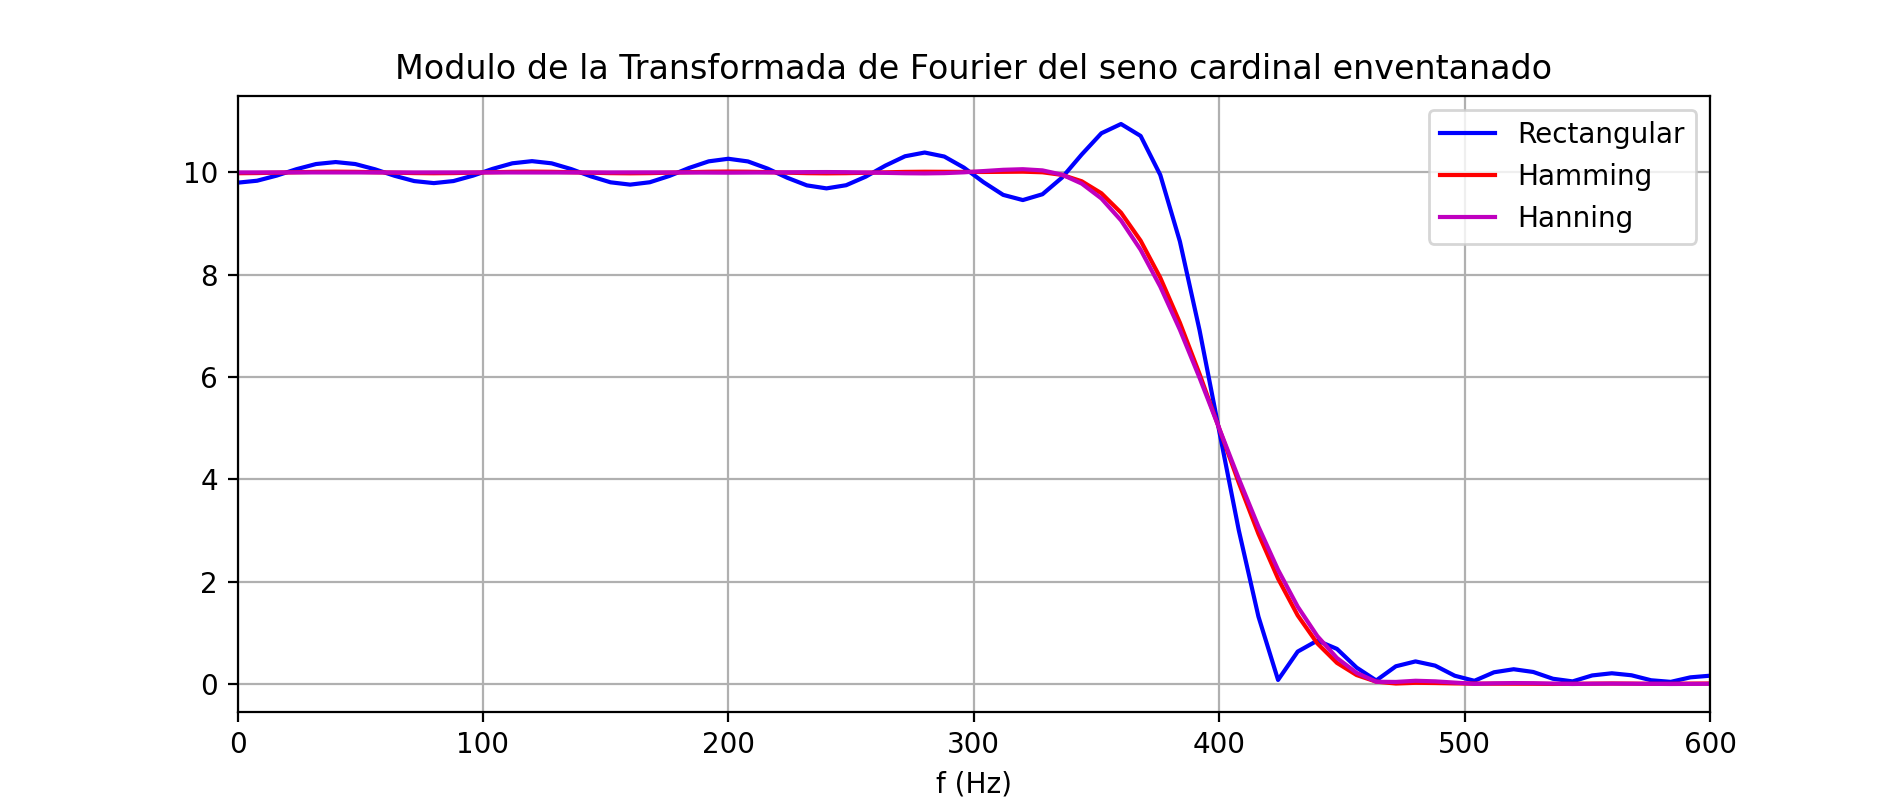

In [54]:
plt.figure(figsize=signal_fig_size)
plt.grid()
plt.plot(f,abs(tdf_rect),'b')
plt.plot(f,abs(tdf_hamm),'r')
plt.plot(f,abs(tdf_hann),'m')
plt.legend(('Rectangular', 'Hamming', 'Hanning'))
plt.title("Modulo de la Transformada de Fourier del seno cardinal enventanado")
plt.xlim(0,600)
plt.xlabel("f (Hz)")
plt.show()

### Observaciones:

Ver compromiso entre caída (ventana rectangular logra mejor caída) y oscilaciones
de Gibbs.

## Coseno: $\cos(2\pi f_c t)$

* Frecuencia de oscilación $f_c = 400 Hz$
* Ventanan de tiempo $T_d = 25 ms$
* Frecuencia de muestreo $f_s = 8 kHz$
* Cantidad de muestras $N = T_d \ F_s = 200$

In [136]:
Td = 0.025
fs = 8000.
fc = 400

m, t = cos(Td, fs, fc)
m = m*np.hanning(len(m))
plot_signal(t, m, "Coseno %.0f Hz" % fc)

<IPython.core.display.Javascript object>

### Transformada del coseno $\frac{1}{2}\left(\delta(f+f_c) + \delta(f-f_c)\right)$

In [137]:
nZeros = 0
tdf, f = TFourier(m, fs, nZeros)
plot_TF(f, tdf, True)

nZeros = 800
tdf, f = TFourier(m, fs, nZeros)
plot_TF(f, tdf, True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Coseno: $\cos(2\pi f_c' t)$
* Frecuencia de oscilación $f_c' = 550 Hz$
* Ventanan de tiempo $T_d = 25 ms$
* Frecuencia de muestreo $f_s = 8 kHz$
* Cantidad de muestras $N = T_d \ F_s = 200$

In [139]:
Td = 0.025
fs = 8000.
fc = 550

m, t = cos(Td, fs, fc)
m = m * np.hanning(len(m))
plot_signal(t, m, "Coseno %.0f Hz" % fc)

<IPython.core.display.Javascript object>

### Transformada del coseno $\frac{1}{2}\left(\delta(f+f_c') + \delta(f-f_c')\right)$

In [140]:
nZeros = 0
tdf, f = TFourier(m, fs, nZeros)
plot_TF(f, tdf, True)

<IPython.core.display.Javascript object>

# Diseño de filtros

## Requerimientos para el diseño de un filtro (LPF)

<center><img src="figures/requerimientos_disenno_filtro_LPF.png" width="400px" alt="Requerimientos para diseño de LPF"></center>


## Filtro FIR por ventanas

Los filtros FIR son filtros con respuesta impulsiva finita (Finite Impulse Response). Esto quiere decir que decir que la respuesta al impulso (o a cualquier otra entrada finita) se hace cero a partir de un cierto $n=N_0$. Generalmente se representan mediante un diagrama de bloques como el de la siguiente figura donde las constantes $b_i$ son los coeficientes del filtro (en este caso de orden $M+1$) representando la ecuación en diferencias 
\begin{equation}
y[n]=b_0 x[n]+ b_1 x[n-1] + \dots + b_M x[n-M]= \sum_{m=0}^Mb_mx[n-m] \label{eq:FIR} \tag{FIR}
\end{equation}

Un diagrama de bloques genérico para un filtro expresado en una ecuación en diferencias se muestra en la siguiente figura. La ecuación en diferencia para un \ref{eq:FIR} es el caso con $a_k=0\,\forall k.$
<center><img src="figures/FIR-IIR.png" width="400px"></center>


Los filtros FIR por ventanas se basan en truncar la respuesta al impulso infinita
de un filtro ideal.

### Diseño de un pasabajos FIR por ventanas

<IPython.core.display.Javascript object>


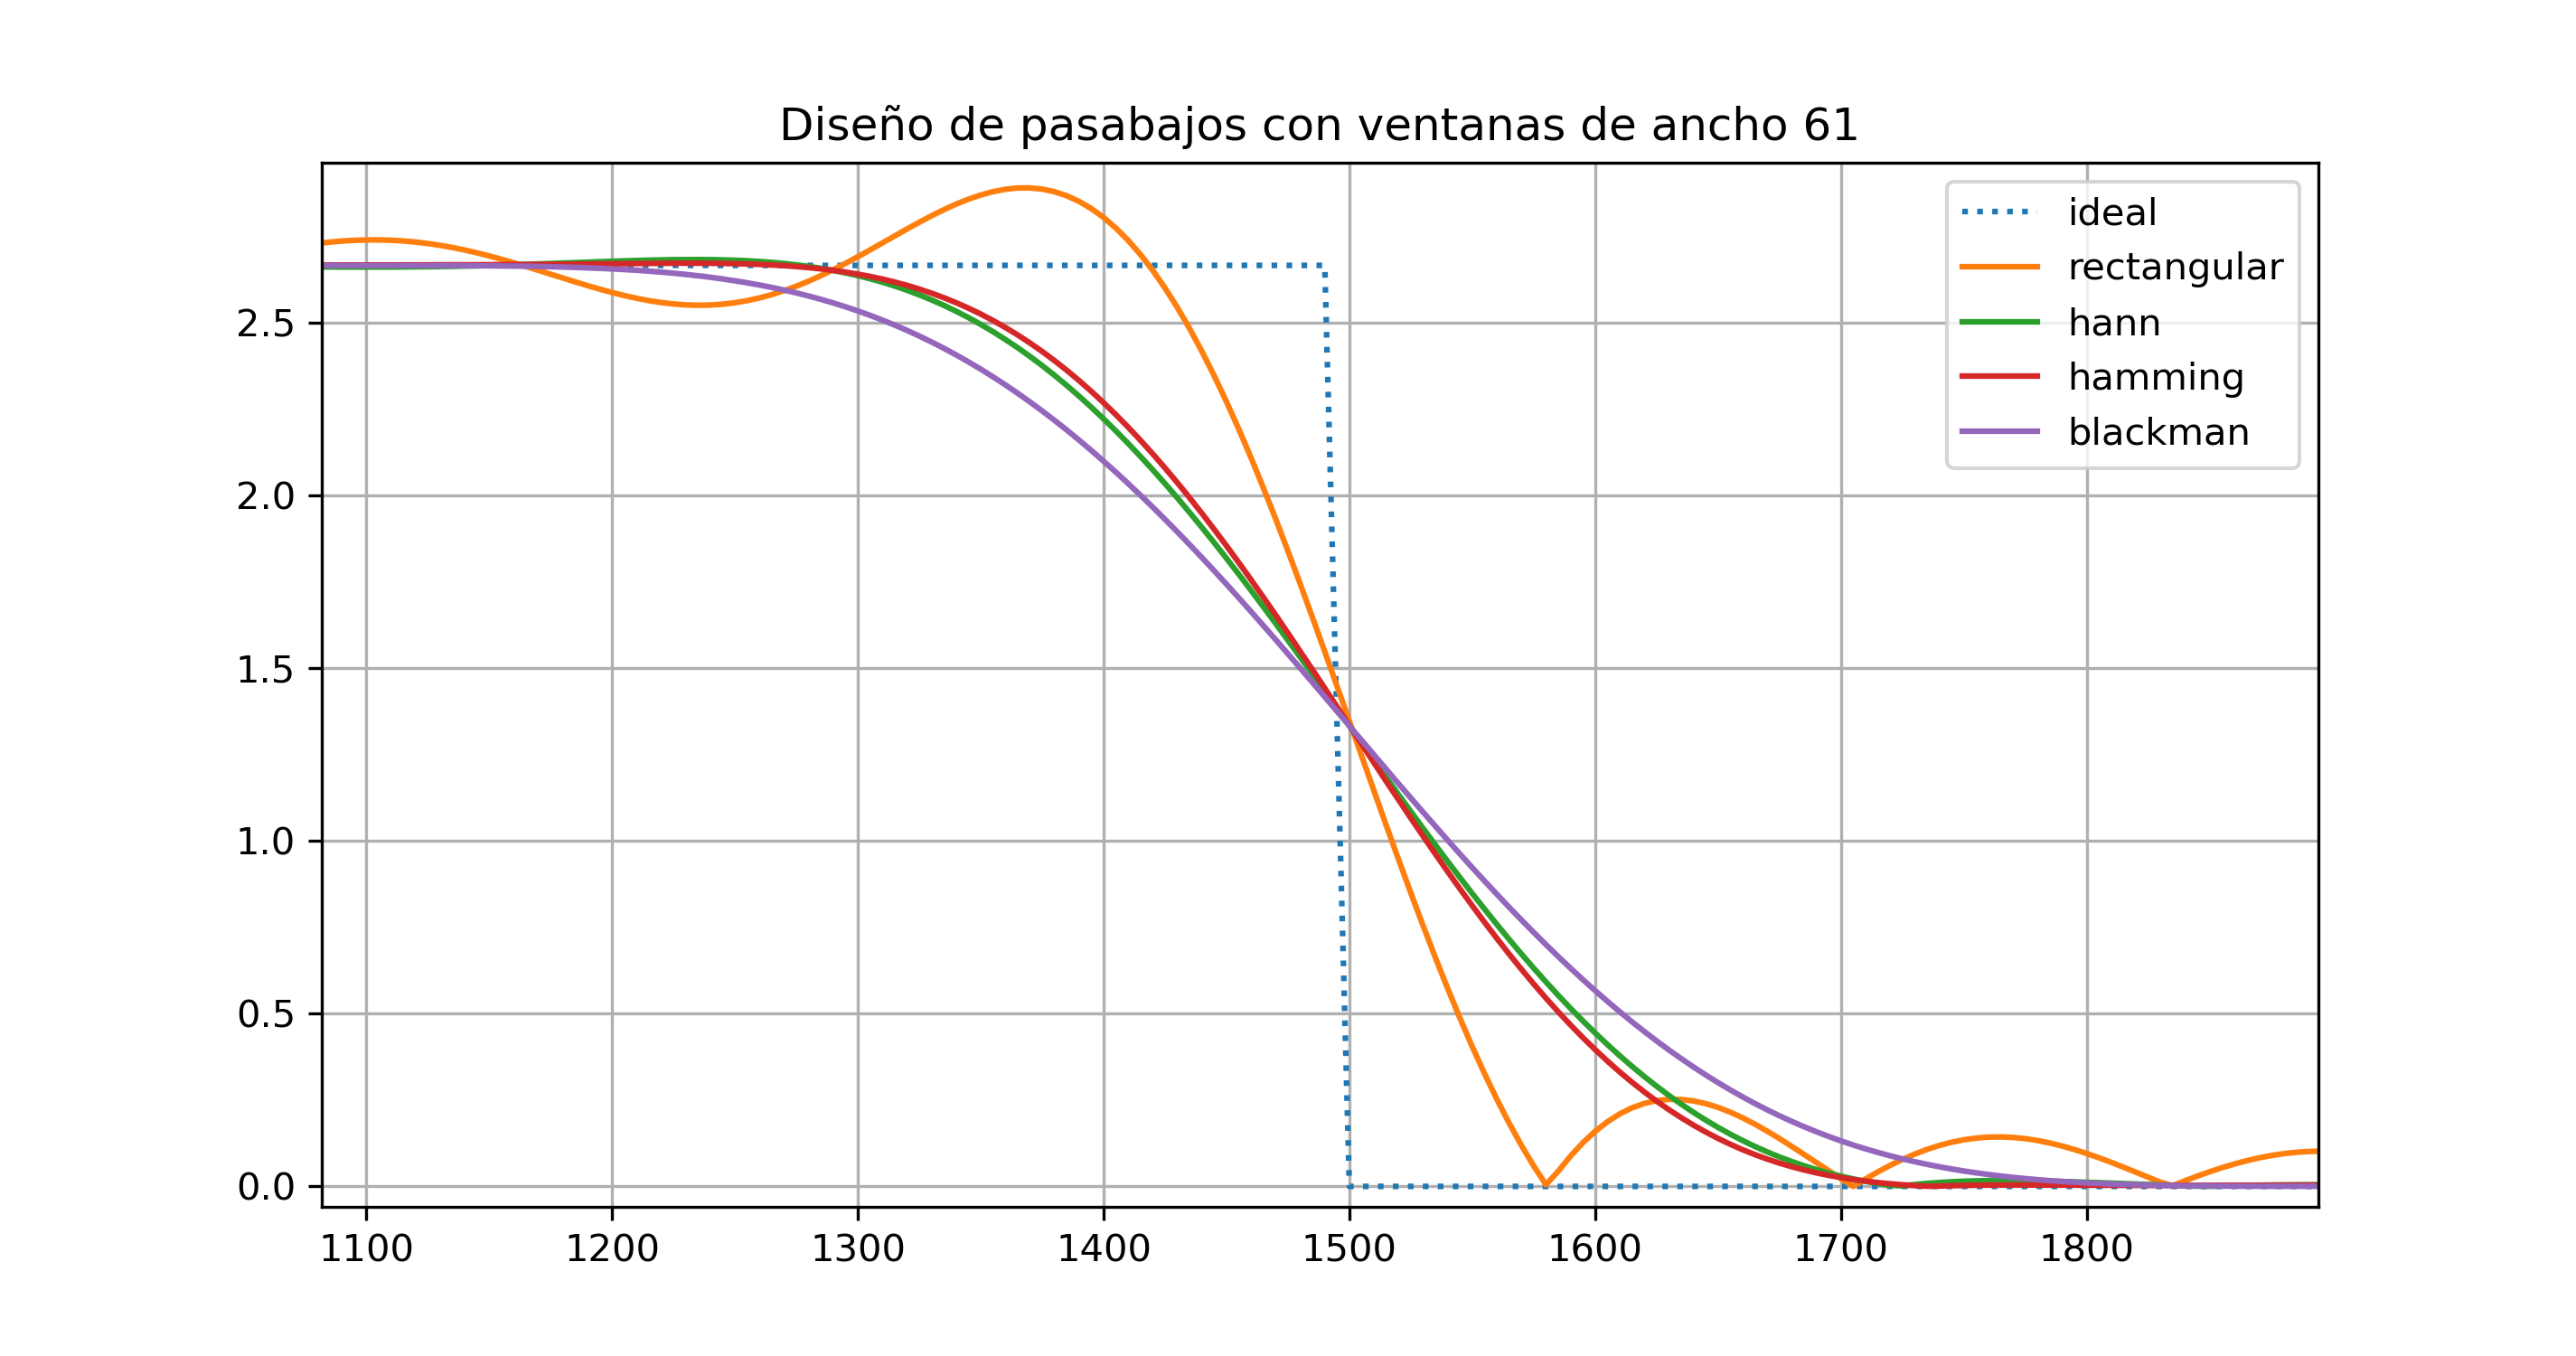

In [141]:
Td = 0.1
fs = 8000.
W = 1500 # Ancho de banda

m, t = sinc(Td, fs, W)
tdf, f = TFourier(m, fs)
hideal = fs/2/W*(abs(f) < W)
M = 30
NM = 2*M+1
plt.figure(figsize=(9.5,5))
plt.plot(f, hideal, ':', label="ideal")
plt.legend()
ventanas = [ 'rectangular', 'hann', 'hamming', 'blackman' ]
for ventana in ventanas:
    mw = recortar_y_enventanar(m, M, ventana)
    tdf, f = TFourier(mw, fs, 800)
    plt.plot(f, abs(tdf), label=ventana)
    plt.legend()

plt.title('Diseño de pasabajos con ventanas de ancho %d' %NM)
plt.grid()
plt.show()

### Pasabajos (LPF)

<IPython.core.display.Javascript object>


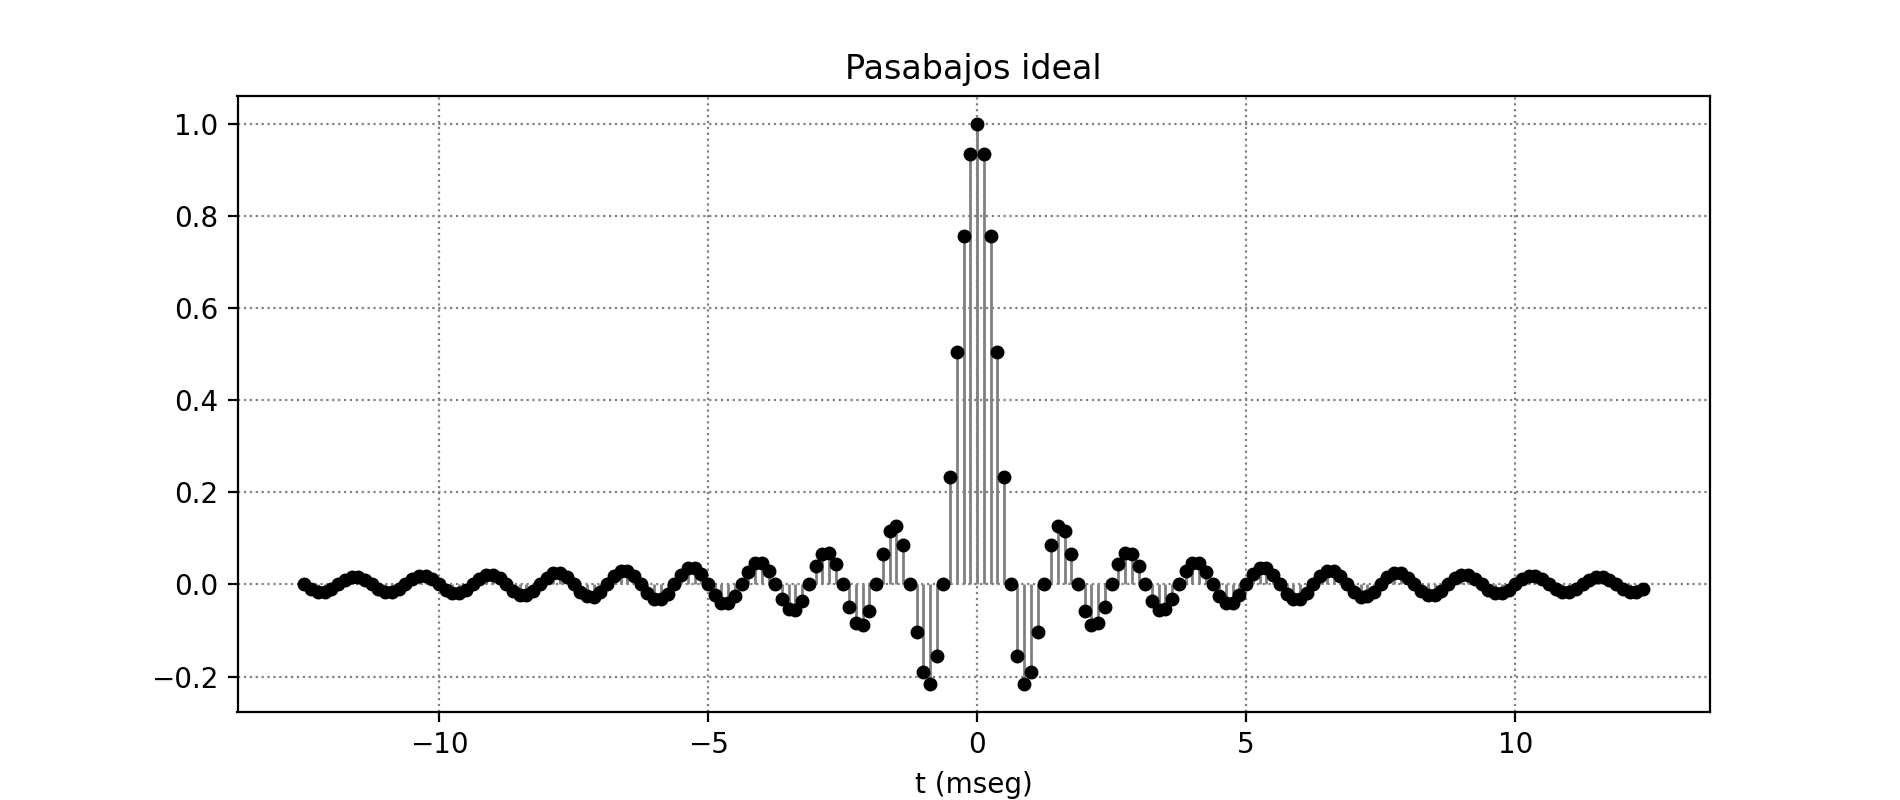

<IPython.core.display.Javascript object>


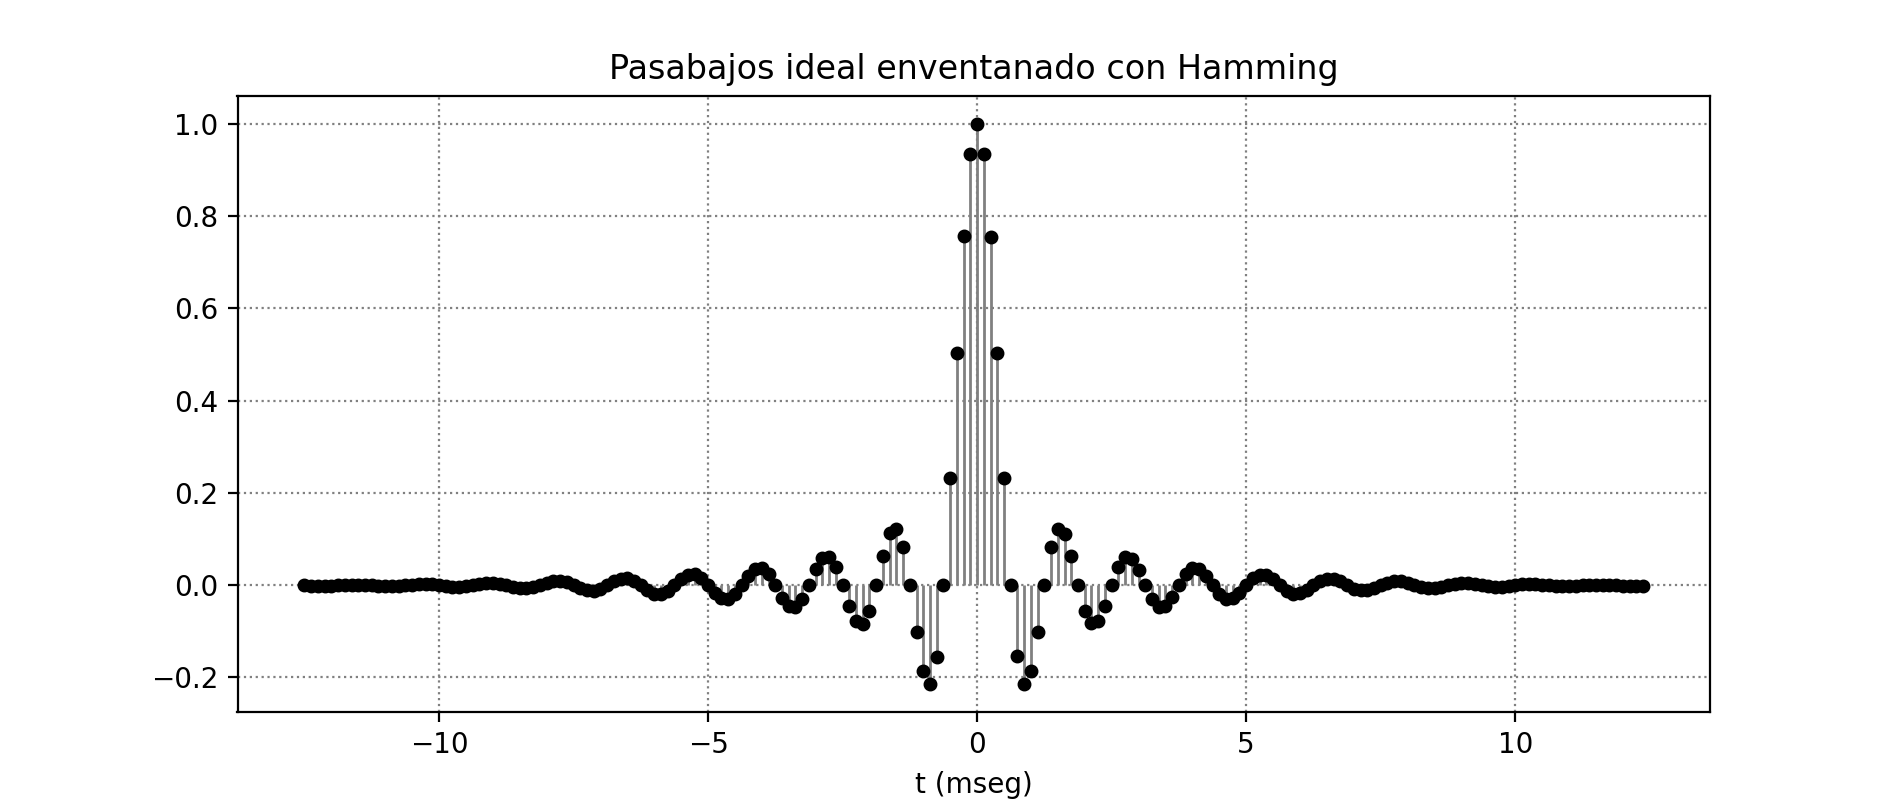

<IPython.core.display.Javascript object>

In [60]:
Td = 0.025
fs = 8000.
W = 800 # Ancho de banda

m, t = sinc(Td, fs, W)

v_hamm = np.hamming(len(m))
plot_signal(t,m,"Pasabajos ideal")
m = m * v_hamm
plot_signal(t,m,"Pasabajos ideal enventanado con Hamming")

tdf, f = TFourier(m, fs)
plot_TF(f, tdf, True)

## Diseño LPF FIR por ventanas con requerimientos

* Frecuencia de muestreo $f_s = 8000Hz$
* Ancho de banda pasante $b_p = 1000Hz$
* Ancho de banda de transición $b_t = 500Hz$
* Banda atenuante $f_a = b_p + b_t$
* Frecuencia de corte $f_c = b_p + b_t/2$
* Ripple de banda pasante $rbp = 0.03$
* Ripple de banda de atenuación $rba = 0.05$

Cantidad de coeficientes: 33 (ventana hann)


<IPython.core.display.Javascript object>


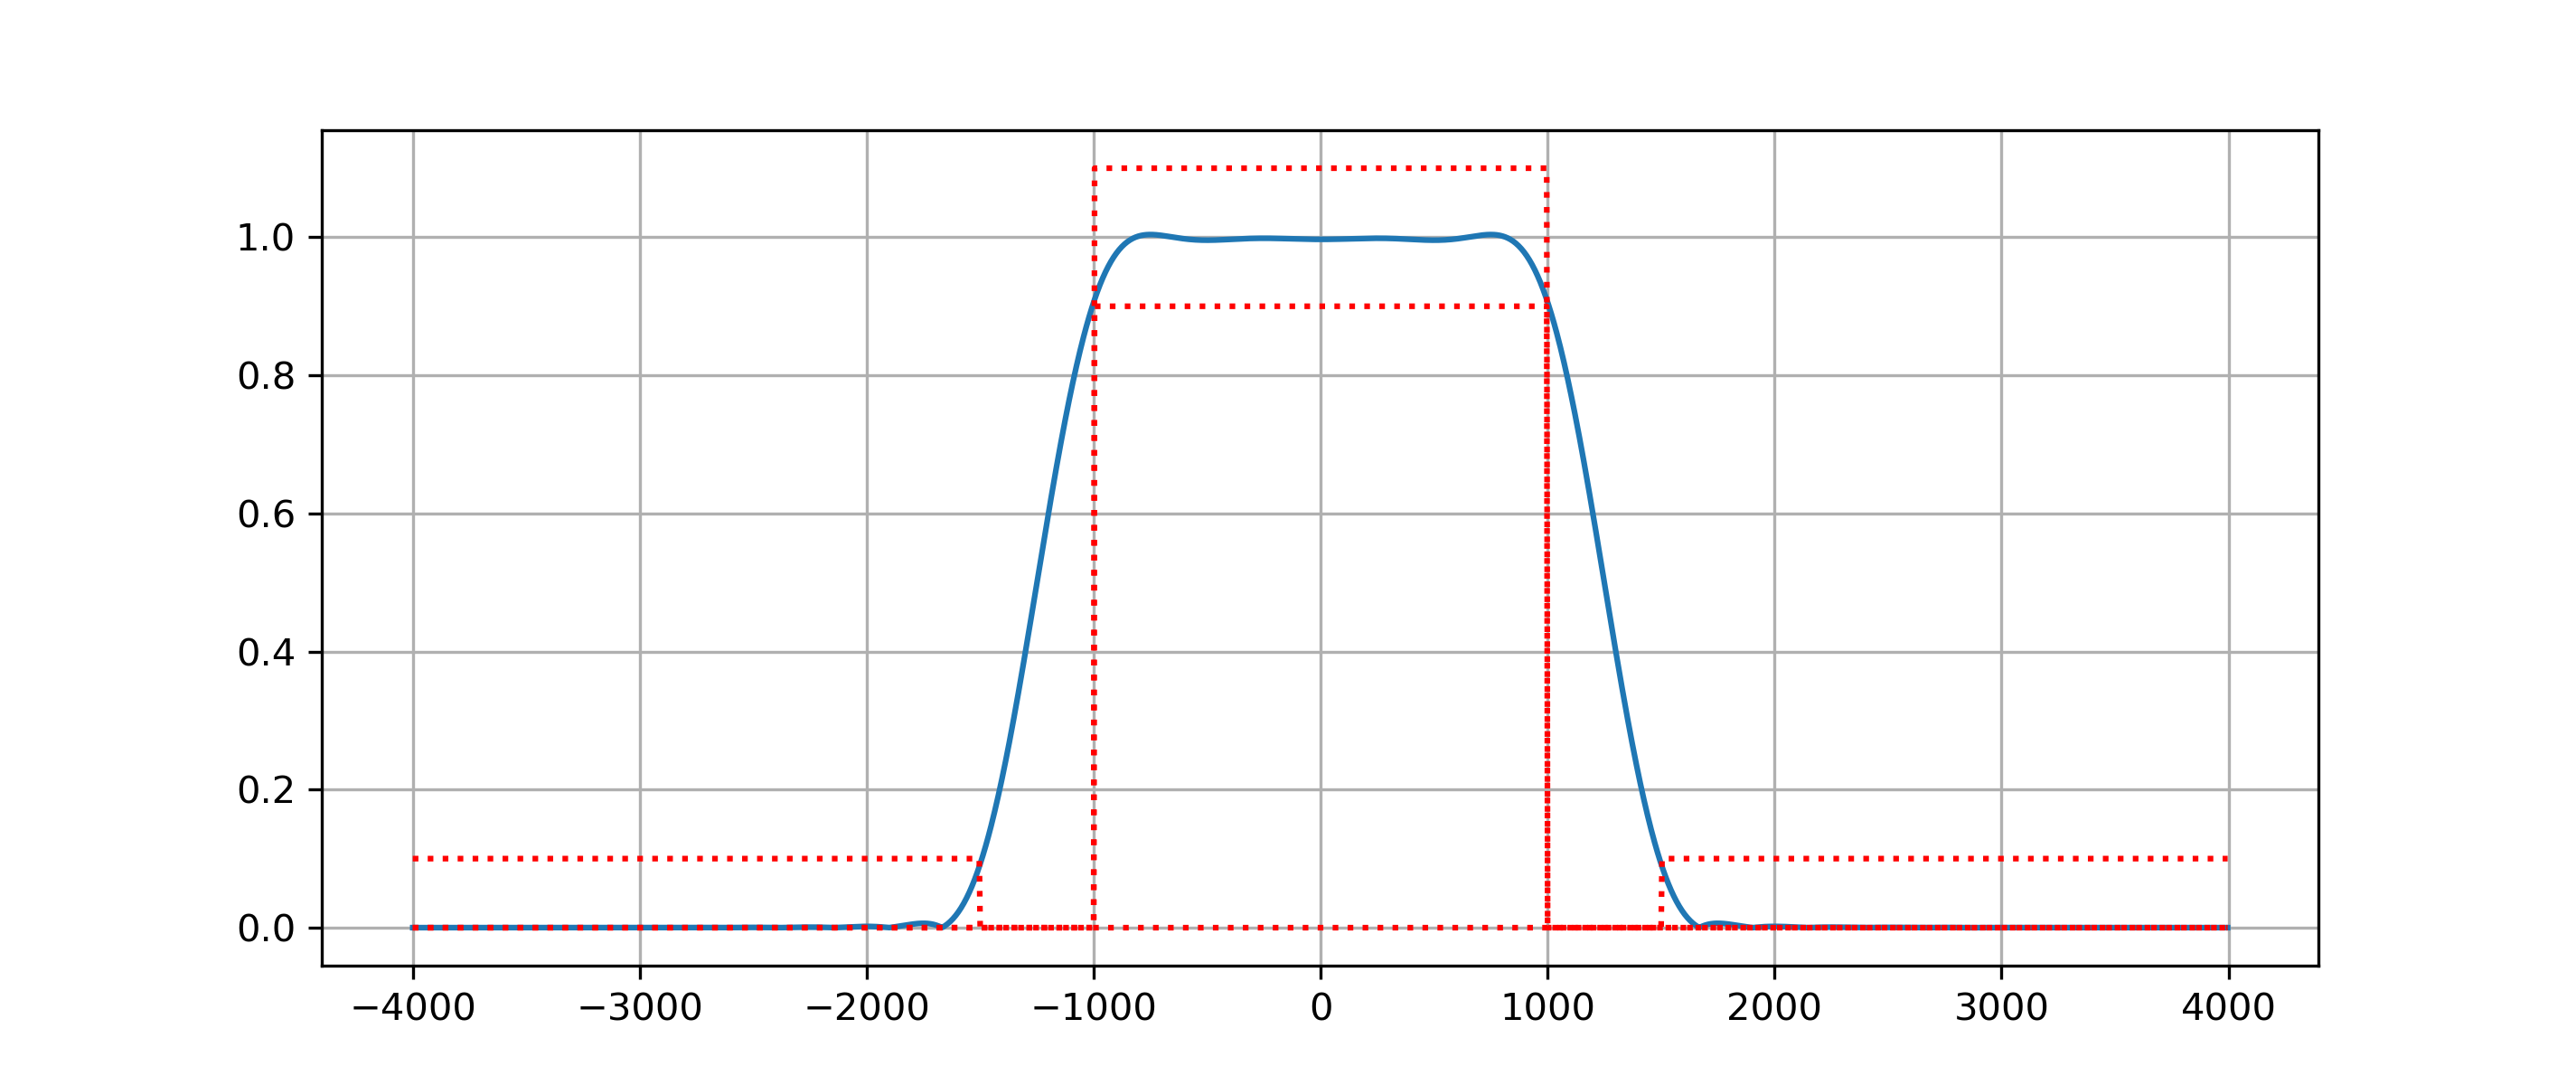

In [155]:
def respuestaFIR(fs, fc, tiempo):
    muestras = (2*fc/fs)*np.sinc(2*fc*tiempo) 
    return muestras

def pasaBajosFIRVentana(fs,fp,fa,fc,rbp,rba,tipoVentana):
    nValfft = 2000
    N = 1
    condiciones = False
    Maxiter = 200
    while (condiciones == False) and (N < Maxiter):
        N += 1
        Td = N/fs
        tiempo = np.arange(-Td/2, Td/2, 1/fs)
        muestras = respuestaFIR(fs, fc, tiempo)
        
        if tipoVentana == 'hann':
            hann = np.hanning(len(muestras))
            muestras = muestras * hann
        elif tipoVentana == 'hamm':
            hamm = np.hamming(len(muestras))
            muestras = muestras * hamm
        elif tipoVentana == 'rect':
            muestras = muestras
        else :
            print('Tipo de ventana (%s) no definido.' % tipoVentana)
            break
    
        tdf = np.fft.fft(muestras,nValfft)
        tdf = abs(np.fft.fftshift(tdf))
        
        indp = int((0.5+fp/fs)*nValfft)
        inda = int((0.5+fa/fs)*nValfft)
    
        condBP = ((np.max(tdf[int(nValfft/2):indp])) < (1+rbp)) and ((np.min(tdf[int(nValfft/2):indp])) > (1-rbp))
        condBA = ((np.max(tdf[inda:])) < rba)
        condiciones = condBP and condBA
        
    if N == (Maxiter):
        print("Máximo de itereaciones alcanzado (%d,%d)" %(Maxiter,N))
        
    print('Cantidad de coeficientes: %d (ventana %s)' %(N, tipoVentana))
    freq = (fs/nValfft)*np.arange(-nValfft/2, nValfft/2)
    
    fig = plt.figure(figsize=signal_fig_size)
    plt.plot(freq, tdf)
    plt.plot(freq, (abs(freq)<fp) * (1+rbp), 'r:')
    plt.plot(freq, (abs(freq)<fp) * (1-rbp), 'r:')
    plt.plot(freq, (abs(freq)>fa) * rba, 'r:')
    plt.grid()
    plt.show()
    
    return muestras
    

###############################################################################################
# Requerimientos de diseño del LPF discreto.
###############################################################################################
fs = 8000.
fp = 1000.
fa = 1500.
fc = fp + (fa-fp)/2
rbp = 0.1
rba = 0.1
# tipoVentana = 'rect'
tipoVentana = 'hamm'
tipoVentana = 'hann'

# Determinación del número de coeficientes necesarios para cumplir los requerimientos.
muestras = pasaBajosFIRVentana(fs,fp,fa,fc,rbp,rba,tipoVentana)

## Filtro IIR (Butterwoth)

### Requerimientos de diseño del LPF discreto.

* Frecuencia de muestreo $f_s = 8000Hz$
* Ancho de banda pasante $b_p = 1500Hz$
* Ancho de banda de transición $b_t = 1000Hz$
* Frecuencia de corte $f_c = b_p + b_t/2$
* Ripple de banda pasante $rbp = 0.1$
* Ripple de banda de atenuación $rba = 0.1$

Filtro de Butterwoth (expresión en $f$ no $\omega$, son similares):
$$
|H(f)|^{2}=\frac{1}{1+\left(f / f_{c}\right)^{2 N}}
$$ donde $N$ es le orden del filtro y $f_c$ la frecuencia de corte. Para calcular los coeficientes del filtro Butter $N$, $f_c$, a partir de los requerimientos, alcanza con evaluar en dos puntos:

Por ejemplo el primer punto puede ser el del ancho de la banda pasante
$$|H(b_p)|^{2}=\frac{1}{1+\left(b_p/ f_{c}\right)^{2 N}} = (1-rbp)^2.$$

El segundo punto puede ser el comienzo de la banda atenuante $$|H(b_p + b_t)|^{2}=\frac{1}{1+\left((b_p + b_t)/ f_{c}\right)^{2 N}} = (rba)^2.$$

Según los requerimientos especificados más arriba los parametros del filtro son
* $N = 5$
* $f_c = 1896Hz$

Si $H_c(s)$ es la función de transferencia en tiempo continuo, la función de transferencia
en tiempo discreto $H_d(z)$ se obtiene sustituyendo $s$ por $$s = 2f_s \left(\frac{1-z^{-1}}{1+z^{-1}}\right).$$

$H_d(z)$ queda $$H_d(z) = H_c\left(2f_s \left(\frac{1-z^{-1}}{1+z^{-1}}\right)\right)$$

b[n]= [9.48395264e-07 1.32775337e-05 8.63039690e-05 3.45215876e-04
 9.49343659e-04 1.89868732e-03 2.84803098e-03 3.25489254e-03
 2.84803098e-03 1.89868732e-03 9.49343659e-04 3.45215876e-04
 8.63039690e-05 1.32775337e-05 9.48395264e-07]
a[n]= [ 1.00000000e+00 -5.59114564e+00  1.58362478e+01 -2.93368013e+01
  3.92276123e+01 -3.97245089e+01  3.12383446e+01 -1.92945395e+01
  9.37433066e+00 -3.55548453e+00  1.03392111e+00 -2.23107646e-01
  3.37169976e-02 -3.18972866e-03  1.42342338e-04]


<IPython.core.display.Javascript object>


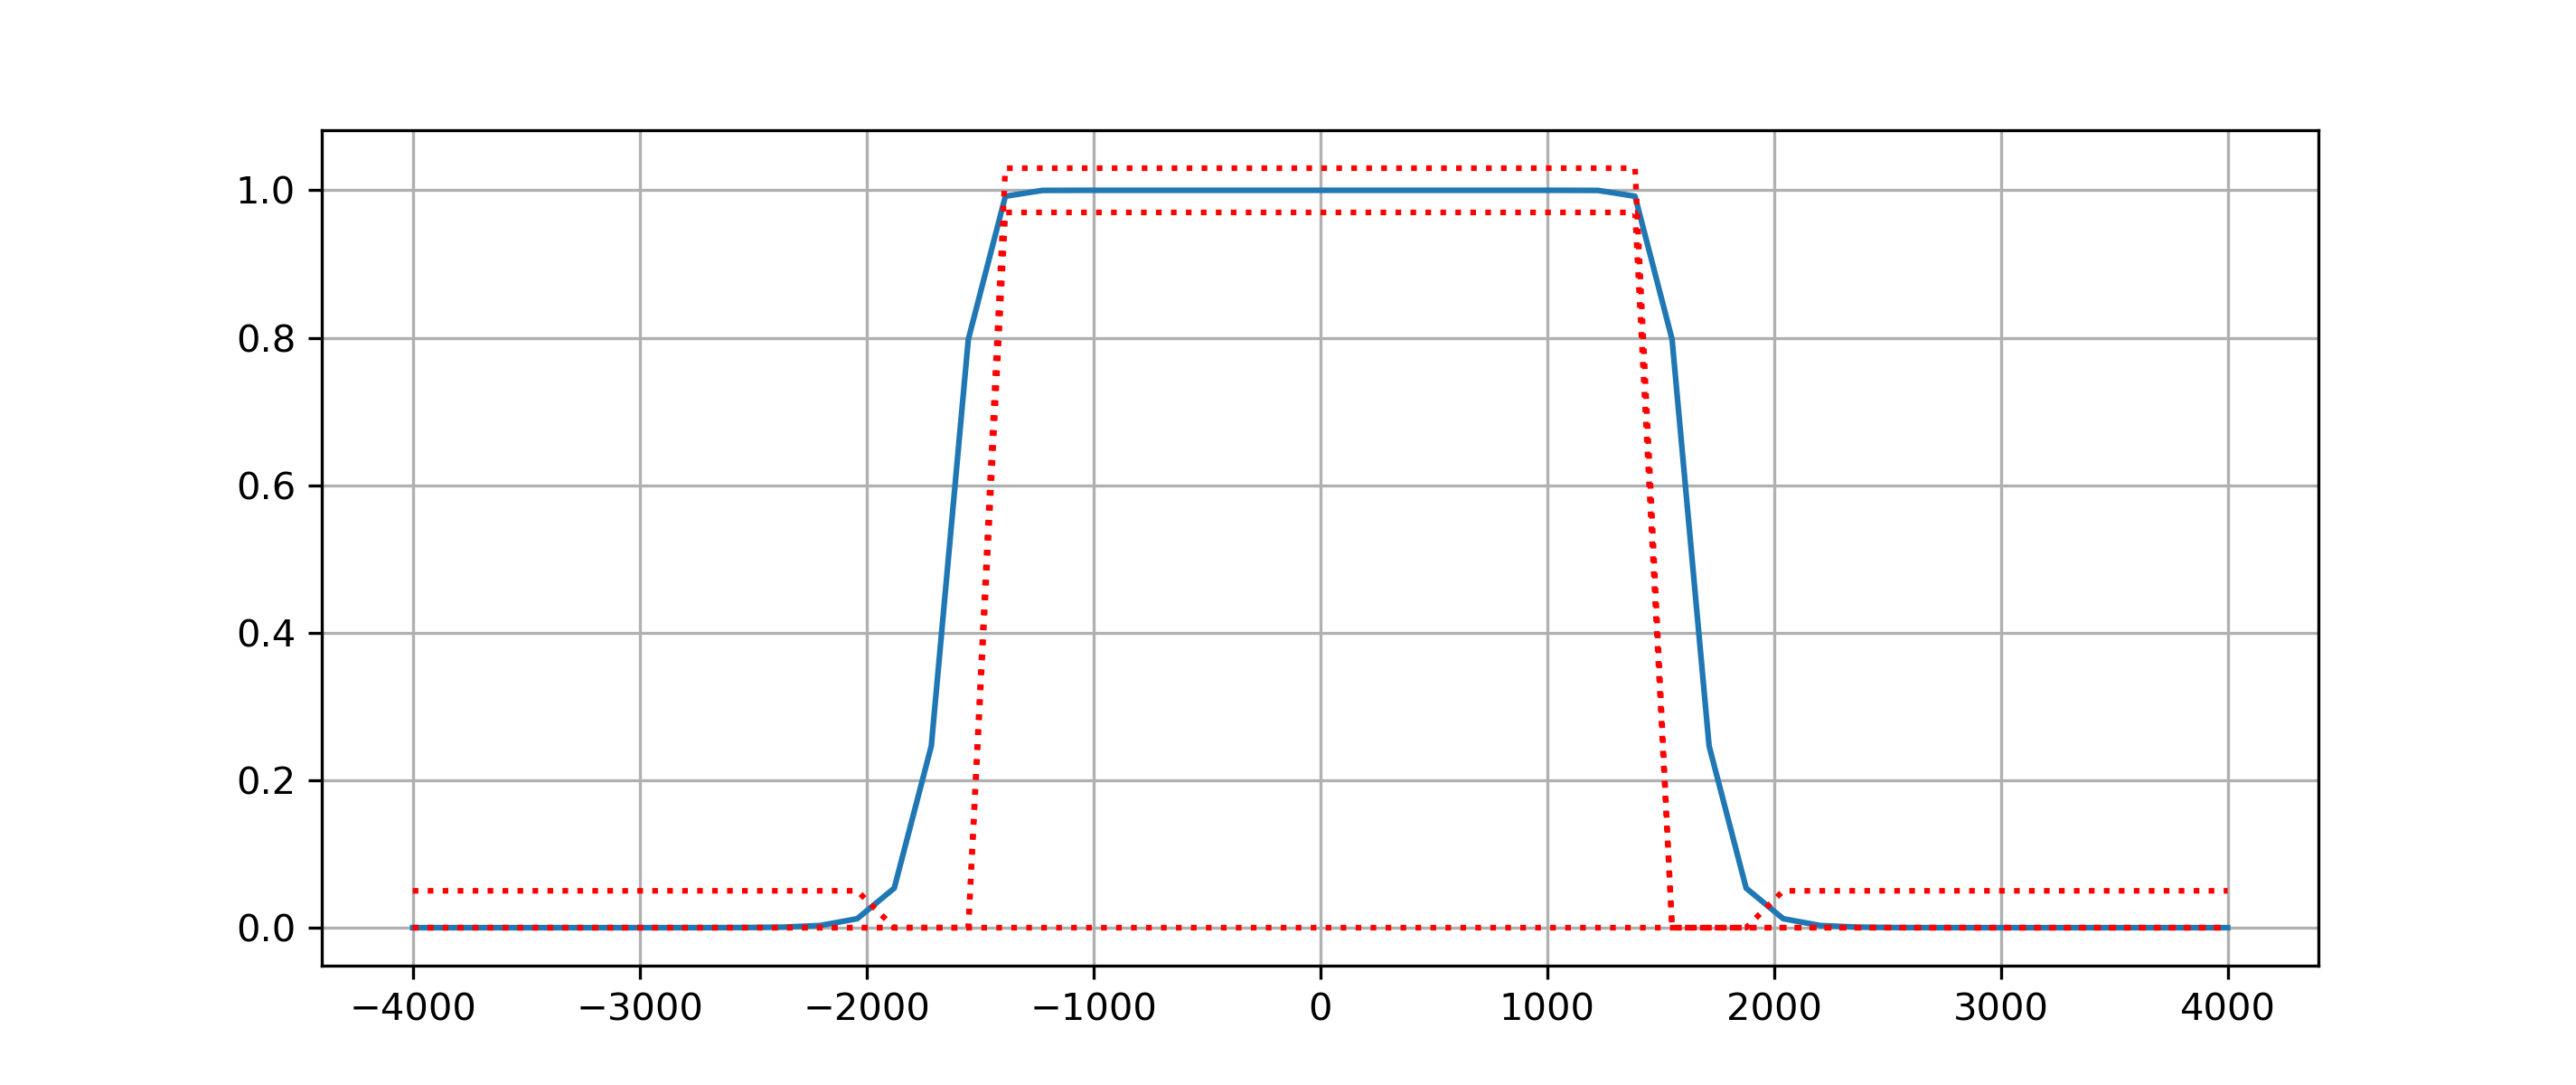

In [162]:
fs = 8000.
fp = 1400.
fa = 2000.
rbp = 0.03
rba = 0.05

N = 14
fc = 1200.

b, a = signal.butter(N, fc/(fs/2), btype='lowpass')
print('b[n]=',b)
print('a[n]=',a)

f, h = signal.freqz(b,a, worN = np.linspace(-fs/2, fs/2))

fig = plt.figure(figsize=signal_fig_size)

plt.plot(f, abs(h))
plt.plot(f, (abs(f)<fp) * (1+rbp), 'r:')
plt.plot(f, (abs(f)<fp) * (1-rbp), 'r:')
plt.plot(f, (abs(f)>fa) * rba, 'r:')
plt.grid()
plt.show()

### Diagrama de Zeros y Polos

Ceros: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Polos: [0.53896516+0.73715748j 0.46384518+0.60260166j 0.41091709+0.4788893j
 0.37389459+0.36389253j 0.34883102+0.25544175j 0.33328383+0.15150754j
 0.32583594+0.05021323j 0.32583594-0.05021323j 0.33328383-0.15150754j
 0.34883102-0.25544175j 0.37389459-0.36389253j 0.41091709-0.4788893j
 0.46384518-0.60260166j 0.53896516-0.73715748j]


<IPython.core.display.Javascript object>


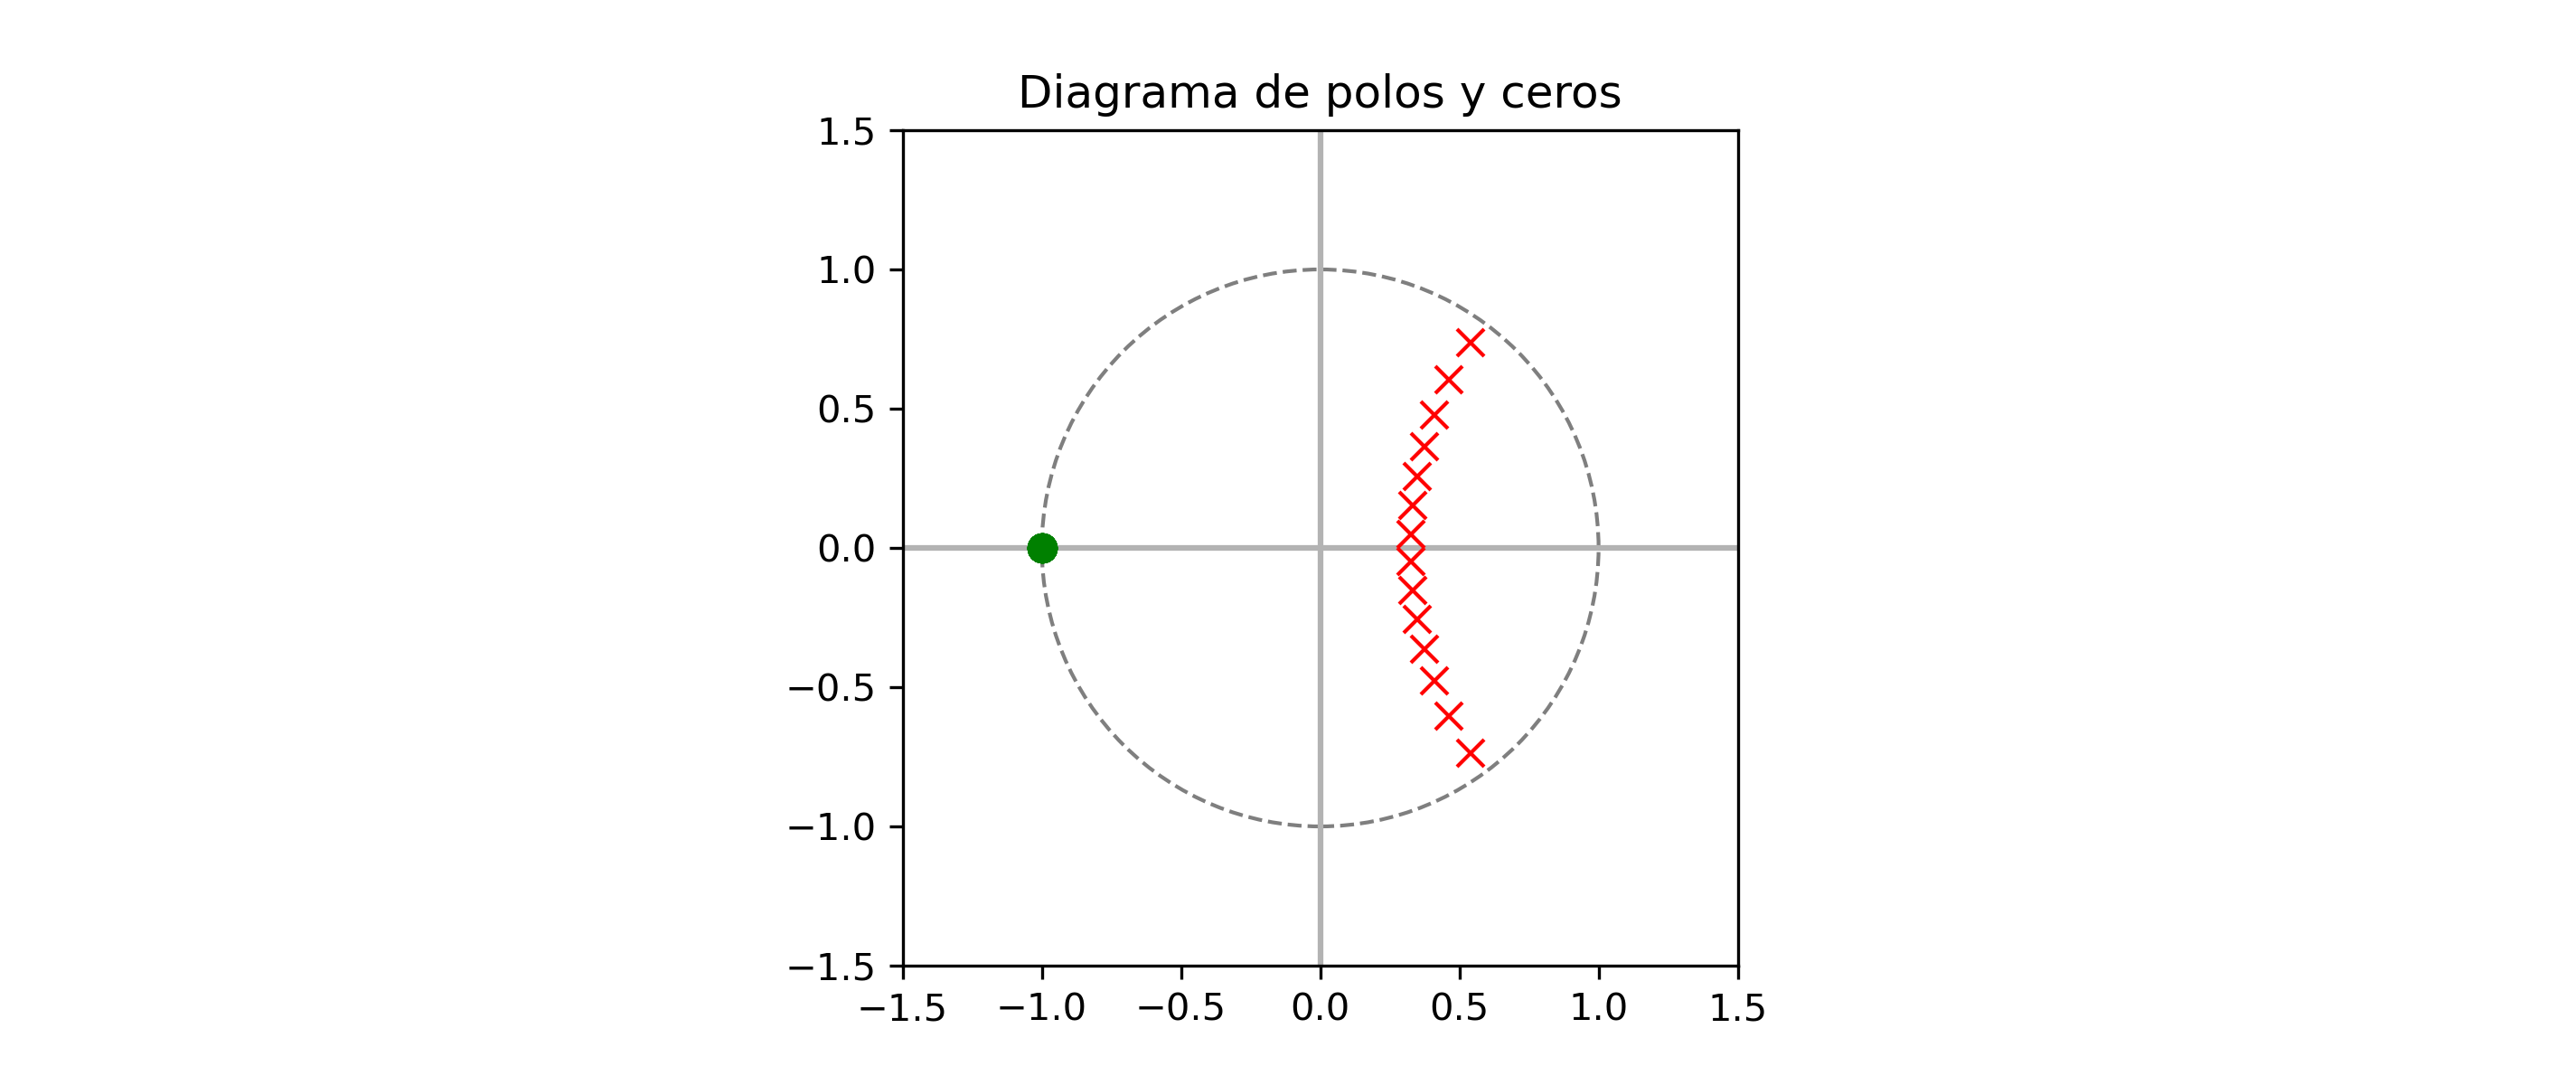

In [163]:
z, p, k = signal.butter(N, 2*fc/fs, btype='lowpass',output='zpk')

print("Ceros:", z)
print("Polos:", p)

zplane(z,p,filename=None)

<IPython.core.display.Javascript object>


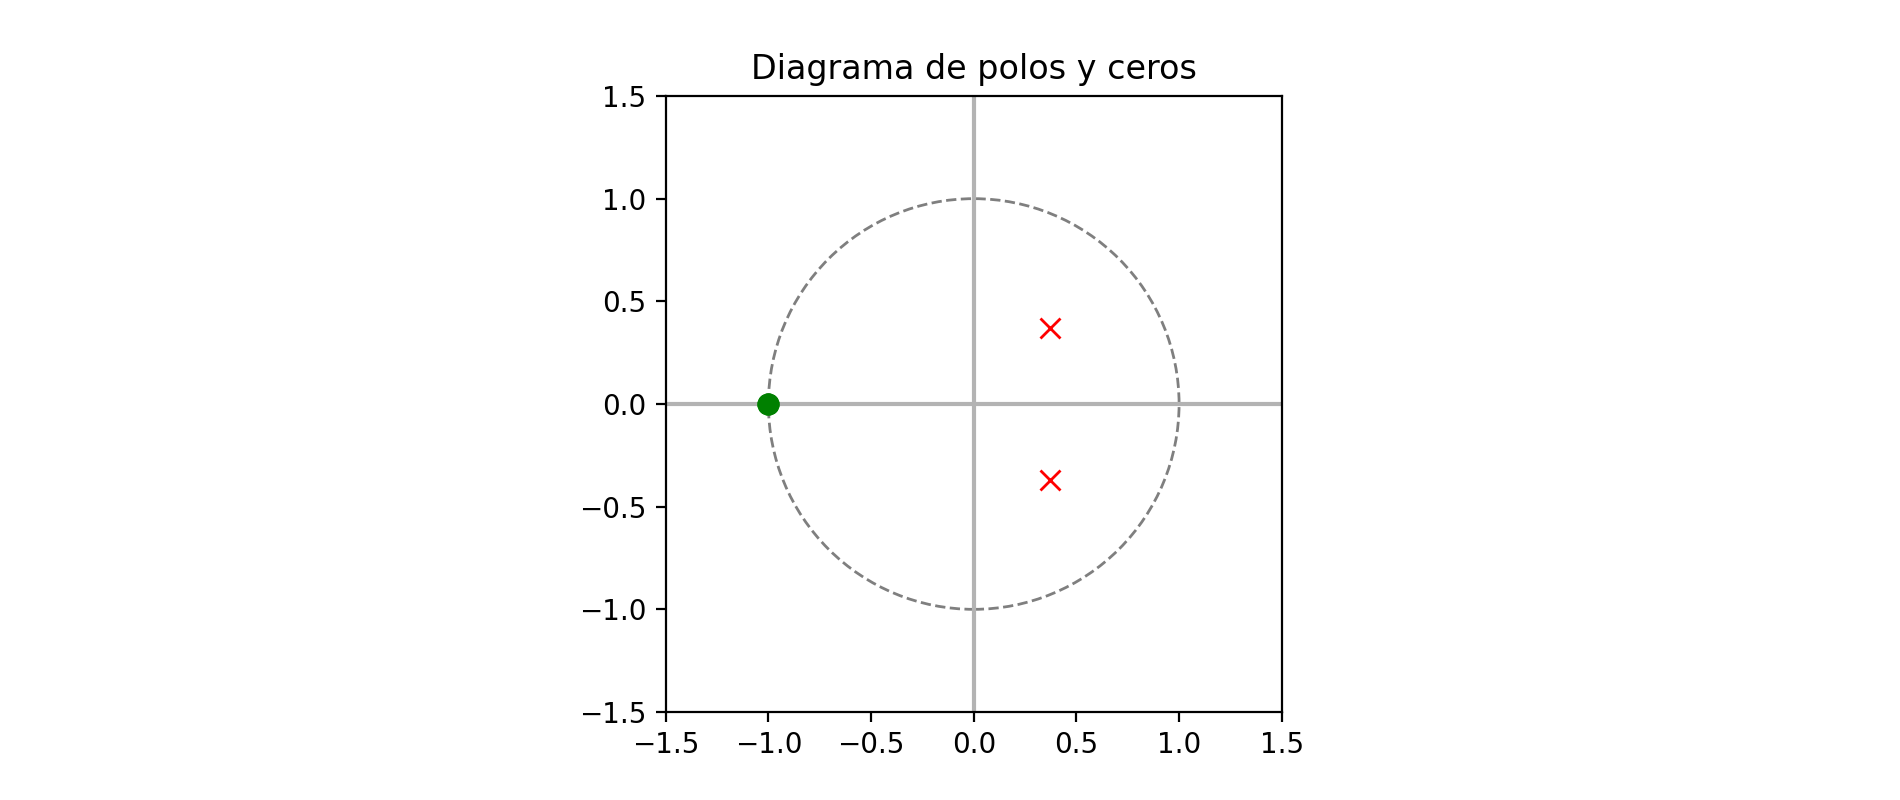

<IPython.core.display.Javascript object>


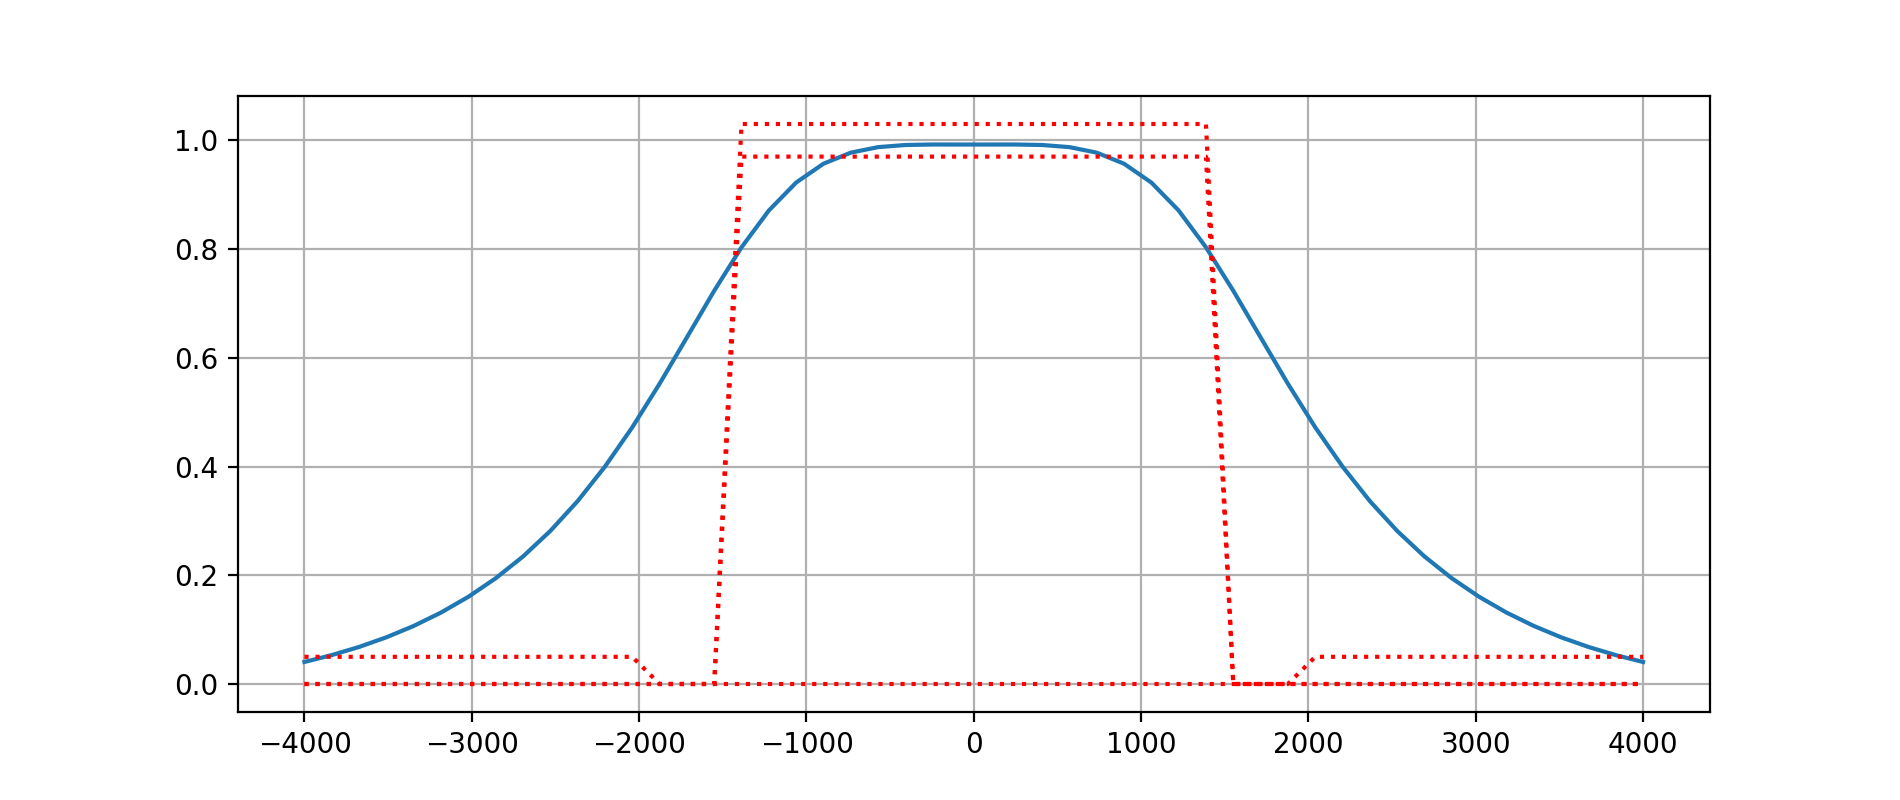

In [65]:
N = 2
z, pm, k = signal.butter(N, 2*fc/fs, btype='lowpass',output='zpk')
pm[0]=0.373 + 0.368j
pm[1]=0.373 - 0.368j

zplane(z,pm,filename=None)

fig = plt.figure(figsize=signal_fig_size)
f, h = signal.freqz_zpk(z, pm, k, worN = np.linspace(-fs/2, fs/2))
plt.plot(f, abs(h))
plt.plot(f, (abs(f)<fp) * (1+rbp), 'r:')
plt.plot(f, (abs(f)<fp) * (1-rbp), 'r:')
plt.plot(f, (abs(f)>fa) * rba, 'r:')
plt.grid()
plt.show()